In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import random as rdm
import os
np.random.seed(0)
import seaborn as sns
from scipy.optimize import linprog

In [2]:
#problem 1
Rfunc1 = np.zeros((10,10))
Rfunc1[-1][-1] = 1.0
Rfunc2 = np.zeros((10, 10))
Rfunc2[1:7,4] = -100.0
Rfunc2[1,5] = -100.0
Rfunc2[1:4,6] = Rfunc2[7:9,6] = -100.0
Rfunc2[3,7] = Rfunc2[7,7] = -100.0
Rfunc2[3:8,8] = -100.0
Rfunc2[-1][-1] = 10.0

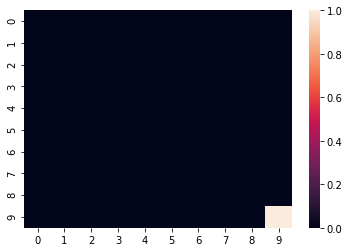

In [3]:
hm1 = sns.heatmap(Rfunc1)

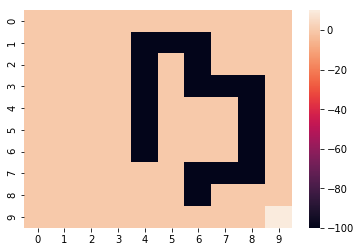

In [4]:
hm2 = sns.heatmap(Rfunc2)

In [5]:
#problem 2
width = 10
height = 10
tp = np.zeros((height * width, 5, 4)) # third dimension is direction, last denotes action
#direction to next state 0 : up 1 : right 2 : down 3 : left 4: stay
#action 0 : up 1 : right 2 : down 3 : left
w = 0.1
dx = [0, 1, 0, -1, 0]
dy = [-1, 0, 1, 0, 0]

In [6]:
def isCorner(x, y, height, width):
    return (((y == height - 1) or (y == 0)) and ((x == width - 1) or (x == 0)))
def isEdge(x, y, height, width):
    return (x == 0) or (x == height - 1) or (y == 0) or(y == width - 1)
def offGrid(x, y, height, width):
    return (x < 0) or (x >= height) or (y < 0) or(y >= width)

In [7]:
def cornerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w / 2.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 2.0
            
def edgeSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w + w / 4.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 4.0   
            
def innerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): # atcion
        for j in range(4):
            if i == j:
                tp[state][j][i] = 1 - w + w / 4.0
            else:
                tp[state][j][i] = w / 4.0

In [8]:
w = 0.1
for i in range(height * width): #calculate transition prob
    x = i // height
    y = i % height
    if isCorner(x, y, height, width):
        cornerSol(x, y, tp, height, width, w)
    elif isEdge(x, y, height, width):
        edgeSol(x, y, tp, height, width, w)
    else:
        innerSol(x, y, tp, height, width, w)

In [9]:
def calStateValue(state, tp, Rfunc, Vs, discount):
    value = np.zeros(4)
    x = state // height
    y = state % height
    for action in range(4):
        for i in range(5):
            x1 = x + dx[i]
            y1 = y + dy[i]
            if offGrid(x1, y1, height, width):
                continue
            state1 = x1 * height + y1
            value[action] += tp[state][i][action] * (Rfunc[y1][x1] + discount * Vs[state1])
    return value
def calVs(Vs, tp, Rfunc, discount, theta):
    while True:
        delta = 0.0
        for s in range(width * height):
            actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
            maxActionValue = max(actionValue)
            delta = max(np.abs(maxActionValue - Vs[s]), delta)
            Vs[s] = maxActionValue
        if delta < theta:
            break

In [10]:
Vs1 = np.zeros(height * width)
discount = 0.8
theta = 0.01
calVs(Vs1, tp, Rfunc1, discount, theta)#calculate state value for each state

In [11]:
from tabulate import tabulate

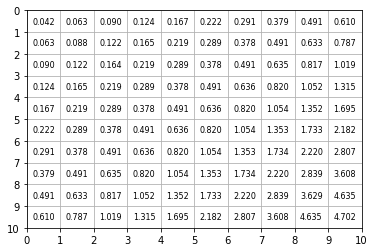

In [12]:
Vs1_2d = Vs1.reshape((height, width))
#print(tabulate(Vs1_2d.T,  tablefmt='fancy_grid'))
fig = plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
for j in range(width):
    for i in range(height):
        plt.text(i + 0.5, j + 0.5, '%.3f' %Vs1_2d[i][j], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8, color='black')
plt.grid()
plt.show()

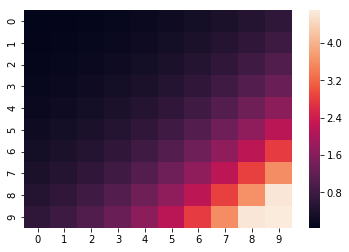

In [13]:
#problem 3
hm3 = sns.heatmap(Vs1_2d.T)

In [14]:
#problem 5
arrows = ['↑','→','↓','←']
def calOptimalAction(optimalAction, tp, Rfunc, Vs, discount):
    for s in range(height * width):
        actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
        optimal = np.argmax(actionValue)
        optimalAction[s] = optimal
def action2Arrow(action, arrows):
    ll = [1, 0, 3, 2]
    return [ll[int(i)] for i in action]

In [15]:
optimalAction1 = np.zeros(height * width)
calOptimalAction(optimalAction1, tp, Rfunc1, Vs1, discount)

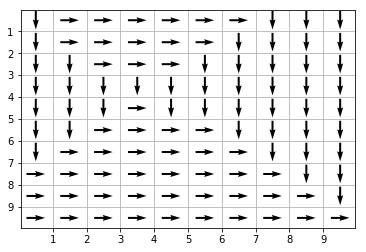

In [16]:
#optimalAction1_2d = optimalAction1.reshape((height, width))
arrows1 = action2Arrow(optimalAction1, arrows)
path1 = np.array(arrows1).reshape((height,width)).T
X = np.arange(0.5, height, 1)
Y = np.arange(0.5, width, 1)
U = np.cos(path1 * np.pi / 2)
V = np.sin(path1 * np.pi / 2)
plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
plt.quiver(X,Y,U,V,units='x',pivot='mid')
plt.grid()
plt.show()

In [17]:
#problem 6
Vs2 = np.zeros(height * width)
calVs(Vs2, tp, Rfunc2, discount, theta)#calculate state value for each state

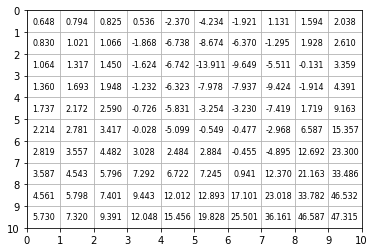

In [18]:
Vs2_2d = Vs2.reshape((height, width))
fig = plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
for j in range(width):
    for i in range(height):
        plt.text(i + 0.5, j + 0.5, '%.3f' %Vs2_2d[i][j], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8, color='black')
plt.grid()
plt.show()

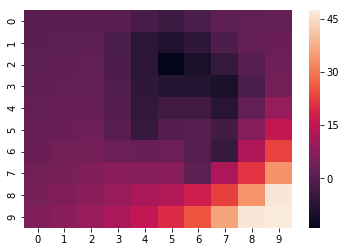

In [19]:
#problem 7
hm4 = sns.heatmap(Vs2_2d.T)

In [20]:
#problem 9
optimalAction2 = np.zeros(height * width)
calOptimalAction(optimalAction2, tp, Rfunc2, Vs2, discount)

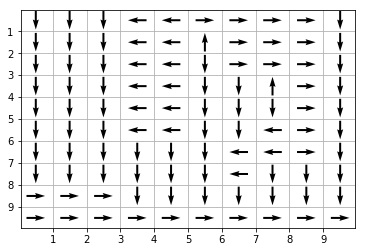

In [21]:
optimalAction2_2d = optimalAction2.reshape((height, width))
arrows2 = action2Arrow(optimalAction2, arrows)
path2 = np.array(arrows2).reshape((height,width)).T
X = np.arange(0.5, height, 1)
Y = np.arange(0.5, width, 1)
U = np.cos(path2 * np.pi / 2)
V = np.sin(path2 * np.pi / 2)
plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
plt.quiver(X,Y,U,V,units='x',pivot='mid')
plt.grid()
plt.show()

# IRL #

In [22]:
def tp2tpm(height, width, tp):
    tpm = np.zeros((height * width, 4, height * width))
    for s in range(tp.shape[0]):
        x = s // height
        y = s % height
        for action in range(tp.shape[2]):
            for i in range(tp.shape[1]):
                x1 = x + dx[i]
                y1 = y + dy[i]
                if not offGrid(x1, y1, height, width):
                    s1 = x1 * height + y1
                    tpm[s][action][s1] = tp[s][i][action]
    return tpm

In [23]:
def calculate_LP_D(a, s, policy, gamma, tp):
    # (Pa1 −Pa)(I−γPa1)−1
#     print(tp.shape)
    return np.dot(tp[int(policy[s]), s] - tp[a, s], np.linalg.inv(np.eye(100) - gamma*tp[int(policy[s])]))

In [24]:
def calculate_accuracy(n_states, ground_truth, extracted_reward):
    Vs = np.zeros(100)
    discount = 0.8
    theta = 0.01
    er = np.zeros([10,10])
    for s in range(100):
        y = int(s / height)
        x = int(s % height)
        er[x,y] = extracted_reward[s]
    calVs(Vs, tp, er, discount, theta)
    optimalAction = np.zeros(height * width)
    calOptimalAction(optimalAction, tp, er, Vs, discount)
    count = 0
    for i in range(n_states):
        if ground_truth[i] == optimalAction[i]:
            count += 1
    return float(count)/float(n_states)

In [25]:
#Question 11:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import solvers,matrix
lamda_list = np.linspace(0,5,500)
A = {0,1,2,3}
n_actions = 4
n_states = 100
gamma = 0.8
tpm = tp2tpm(height, width, tp)
# print(tpm.shape)
transition_probability = np.transpose(tpm, (1, 0, 2))
Rmax1 = 0.0
for i in range(0,10):
    for j in range(0,10):
        Rmax1 = max(Rmax1, abs(Rfunc1[i,j]))   
Rmax2 = 0.0
for i in range(0,10):
    for j in range(0,10):
        Rmax2 = max(Rmax2, abs(Rfunc2[i,j]))  

In [26]:
def normalize(vals):
    min_val = np.min(vals)
    max_val = np.max(vals)
    return (vals - min_val) / (max_val - min_val)

In [27]:
def perform_IRL_4Attrs(optimalAction, transition_probability, Rmax, lamda_list):
    accuracy = []
    for lamda in lamda_list:
        n_states = 100
        policy = optimalAction
        C = -np.hstack([np.zeros(100), np.ones(100), -lamda*np.ones(100), np.zeros(100)]) 
#         print(C.shape)   
#         print(A - {policy[1]})
        T_stack = np.vstack([
                calculate_LP_D(a, s, policy, gamma, transition_probability)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        one_stack = np.vstack([
                np.eye(1, n_states, s)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        # X = [R, T, U, M]
        # (Pa1 −Pa)(I−γPa1)−1 * R >= T => -(Pa1 −Pa)(I−γPa1)−1 * R <= -T => -(Pa1 −Pa)(I−γPa1)−1 * R + T <= 0
        D_0 = np.hstack([-T_stack, one_stack,np.zeros((300,100)),np.zeros((300,100))])
        # (Pa1 −Pa)(I−γPa1)−1 * R >= 0 => -(Pa1 −Pa)(I−γPa1)−1 * R <= 0
        D_1 = np.hstack([-T_stack, np.zeros((300,100)),np.zeros((300,100)),np.zeros((300,100))])
        # R <= u and R >= -u => R-u<=0 and -R-u <=0
        D_2 = np.hstack([np.eye(n_states),np.zeros((100,100)),-np.eye(n_states),np.zeros((100,100))])
        D_3 = np.hstack([-np.eye(n_states),np.zeros((100,100)),-np.eye(n_states),np.zeros((100,100))])
        # R <= Rmax and R >= -Rmax => R - Rmax <=0 and -R - Rmax <=0
        D_4 = np.hstack([np.eye(n_states), np.zeros((100,100)), np.zeros((100,100)), -np.eye(n_states)])
        D_5 = np.hstack([-np.eye(n_states), np.zeros((100,100)), np.zeros((100,100)), -np.eye(n_states)])

        D = np.vstack([D_0, D_1, D_2, D_3, D_4, D_5])
        d = matrix(D)
        B = np.zeros((1000,1))
        b = matrix(B)
        c = matrix(C)
        results = solvers.lp(c, d, b)
        r = np.asarray(results["x"][:n_states], dtype=np.double)
        # print(r)
        res = r.reshape((n_states,))
#         print(res)
        temp_acc = calculate_accuracy(100, optimalAction, res)
        print(temp_acc)
        accuracy.append(temp_acc)
    return {'accuracy':accuracy, 'reward': res}

In [28]:
def perform_IRL_3Attrs(policy, transition_probability, Rmax, lamda_list):
    accuracy = []
    for lamda in lamda_list:
        n_states = 100
        C = -np.hstack([np.zeros(100), np.ones(100), -lamda*np.ones(100)]) 
#         print(C)
#         print(C.shape)   
#         print(A - {policy[1]})
        T_stack = np.vstack([
                calculate_LP_D(a, s, policy, gamma, transition_probability)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        one_stack = np.vstack([
                np.eye(1, n_states, s)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        # X = [R, T, U, RMax]
        # (Pa1 −Pa)(I−γPa1)−1 * R >= T => -(Pa1 −Pa)(I−γPa1)−1 * R <= -T => -(Pa1 −Pa)(I−γPa1)−1 * R + T <= 0
        D_0 = np.hstack([-T_stack, one_stack,np.zeros((300,100))])
        # (Pa1 −Pa)(I−γPa1)−1 * R >= 0 => -(Pa1 −Pa)(I−γPa1)−1 * R <= 0
        D_1 = np.hstack([-T_stack, np.zeros((300,100)),np.zeros((300,100))])
        # R <= u and R >= -u => R-u<=0 and -R-u <=0
        D_2 = np.hstack([np.eye(n_states),np.zeros((100,100)),-np.eye(n_states)])
        D_3 = np.hstack([-np.eye(n_states),np.zeros((100,100)),-np.eye(n_states)])
        # R <= Rmax and R >= -Rmax => R - Rmax <=0 and -R - Rmax <=0
        D_4 = np.hstack([np.eye(n_states), np.zeros((100,100)), np.zeros((100,100))])
        D_5 = np.hstack([-np.eye(n_states), np.zeros((100,100)), np.zeros((100,100))])

        D = np.vstack([D_0, D_1, D_2, D_3, D_4, D_5])        
        d = matrix(D)
        b1 = np.array([0.0 for _ in range(800)])
        b2 = np.array([Rmax for _ in range(200)])

        b = np.concatenate((b2, b1), axis=0)
        b = np.mat(b).T
        b = matrix(b)
        c = matrix(C)
        results = solvers.lp(c, d, b)
        r = np.asarray(results["x"][:n_states], dtype=np.double)
        # print(r)
        res = r.reshape((n_states,))
#         print(res)
        temp_acc = calculate_accuracy(100, policy, res)
        print(temp_acc)
        accuracy.append(temp_acc)
    return {'accuracy':accuracy, 'reward': res}

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.5706e+00 -0.0000e+00  7e+02  1e+01  7e+00  3e+00
 2: -7.5495e+00 -0.0000e+00  2e+03  1e+01  6e+00  8e+00
 3: -6.6356e+01 -0.0000e+00  2e+04  1e+01  7e+00  7e+01
 4: -1.2930e+03 -0.0000e+00  5e+05  1e+01  7e+00  1e+03
 5: -1.2779e+05 -0.0000e+00  5e+07  1e+01  7e+00  1e+05
 6: -1.2779e+07 -0.0000e+00  5e+09  1e+01  7e+00  1e+07
 7: -1.2779e+09 -0.0000e+00  5e+11  1e+01  7e+00  1e+09
Certificate of dual infeasibility found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.6041e+00 -0.0000e+00  7e+02  1e+01  7e+00  3e+00
 2: -7.1735e+00 -0.0000e+00  2e+03  1e+01  6e+00  8e+00
 3: -6.1204e+01 -0.0000e+00  2e+04  1e+01  7e+00  6e+01
 4: -1.1753e+03 -0.0000e+00  4e+05  1e+01  7e+00  1e+03
 5: -1.1589e+05 -0.0000e+00  4e+07  1e+01  7e+00  1e+05
 6: -1.1589e+07 -0.0000e+00  4e+09  1e+01  7e+00  1e+07
 7: -1.

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.9473e+00 -0.0000e+00  5e+02  1e+01  6e+00  3e+00
 2: -4.1149e+00 -0.0000e+00  5e+02  8e+00  4e+00  4e+00
 3: -2.0782e+01 -0.0000e+00  3e+03  7e+00  3e+00  2e+01
 4: -4.1967e+02 -0.0000e+00  6e+04  7e+00  3e+00  4e+02
 5: -3.9700e+04 -0.0000e+00  6e+06  7e+00  3e+00  4e+04
 6: -3.9700e+06 -0.0000e+00  6e+08  7e+00  3e+00  4e+06
 7: -3.9700e+08 -0.0000e+00  6e+10  7e+00  3e+00  4e+08
Certificate of dual infeasibility found.
0.69
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.9628e+00 -0.0000e+00  5e+02  1e+01  6e+00  3e+00
 2: -4.0069e+00 -0.0000e+00  5e+02  8e+00  4e+00  4e+00
 3: -1.9312e+01 -0.0000e+00  3e+03  6e+00  3e+00  2e+01
 4: -3.8779e+02 -0.0000e+00  5e+04  7e+00  3e+00  4e+02
 5: -3.6673e+04 -0.0000e+00  5e+06  7e+00  3e+00  4e+04
 6: -3.6672e+06 -0.0000e+00  5e+08  7e+00  3e+00  4e+06
 7: -3

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -3.1270e+00 -0.0000e+00  4e+02  1e+01  5e+00  3e+00
 2: -3.1205e+00 -0.0000e+00  3e+02  6e+00  3e+00  3e+00
 3: -6.2093e+00 -0.0000e+00  4e+02  4e+00  2e+00  6e+00
 4: -9.3348e+01 -0.0000e+00  7e+03  4e+00  2e+00  9e+01
 5: -5.4610e+03 -0.0000e+00  4e+05  4e+00  2e+00  5e+03
 6: -5.4602e+05 -0.0000e+00  4e+07  4e+00  2e+00  5e+05
 7: -5.4602e+07 -0.0000e+00  4e+09  4e+00  2e+00  5e+07
Certificate of dual infeasibility found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -3.1348e+00 -0.0000e+00  3e+02  1e+01  5e+00  3e+00
 2: -3.0809e+00 -0.0000e+00  2e+02  6e+00  3e+00  3e+00
 3: -5.7743e+00 -0.0000e+00  4e+02  4e+00  2e+00  6e+00
 4: -7.9253e+01 -0.0000e+00  6e+03  4e+00  2e+00  8e+01
 5: -4.0675e+03 -0.0000e+00  3e+05  4e+00  2e+00  4e+03
 6: -4.0666e+05 -0.0000e+00  3e+07  4e+00  2e+00  4e+05
 7: -4

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -3.1105e+00 -0.0000e+00  3e+02  1e+01  5e+00  3e+00
 2: -2.5796e+00 -0.0000e+00  2e+02  6e+00  3e+00  3e+00
 3: -2.5614e+00 -0.0000e+00  1e+02  3e+00  1e+00  3e+00
 4: -1.5419e+01 -0.0000e+00  9e+02  2e+00  1e+00  2e+01
 5: -2.3732e+02 -0.0000e+00  1e+04  2e+00  1e+00  2e+02
 6: -2.3377e+04 -0.0000e+00  1e+06  2e+00  1e+00  2e+04
 7: -2.3376e+06 -0.0000e+00  1e+08  2e+00  1e+00  2e+06
 8: -2.3376e+08 -0.0000e+00  1e+10  2e+00  1e+00  2e+08
Certificate of dual infeasibility found.
0.69
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -3.1011e+00 -0.0000e+00  3e+02  1e+01  5e+00  3e+00
 2: -2.5429e+00 -0.0000e+00  2e+02  5e+00  2e+00  3e+00
 3: -2.4213e+00 -0.0000e+00  1e+02  3e+00  1e+00  3e+00
 4: -1.3686e+01 -0.0000e+00  8e+02  2e+00  1e+00  1e+01
 5: -2.0034e+02 -0.0000e+00  1e+04  2e+00  1e+00  2e+02
 6: -1

0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.9352e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -2.1089e+00 -0.0000e+00  1e+02  5e+00  2e+00  2e+00
 3: -1.1979e+00 -0.0000e+00  6e+01  2e+00  9e-01  1e+00
 4: -2.7742e+00 -0.0000e+00  1e+02  1e+00  6e-01  3e+00
 5: -3.2431e+01 -0.0000e+00  2e+03  1e+00  6e-01  3e+01
 6: -2.9572e+03 -0.0000e+00  2e+05  1e+00  6e-01  3e+03
 7: -2.9570e+05 -0.0000e+00  2e+07  1e+00  6e-01  3e+05
 8: -2.9570e+07 -0.0000e+00  2e+09  1e+00  6e-01  3e+07
Certificate of dual infeasibility found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.9197e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -2.0779e+00 -0.0000e+00  1e+02  5e+00  2e+00  2e+00
 3: -1.1348e+00 -0.0000e+00  6e+01  2e+00  8e-01  1e+00
 4: -2.4366e+00 -0.0000e+00  1e+02  1e+00  5e-01  2e+00
 5: -2.8432e+01 -0.0000e+00  2e+03  1e+00  6e-01  3e+01
 6:

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.6688e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -1.7019e+00 -0.0000e+00  9e+01  4e+00  2e+00  2e+00
 3: -5.3504e-01 -0.0000e+00  3e+01  1e+00  6e-01  6e-01
 4: -3.7731e-01 -0.0000e+00  2e+01  6e-01  3e-01  4e-01
 5: -3.1329e+00 -0.0000e+00  3e+02  9e-01  4e-01  3e+00
 6: -1.2972e+02 -0.0000e+00  1e+04  8e-01  3e-01  1e+02
 7: -1.2953e+04 -0.0000e+00  1e+06  8e-01  3e-01  1e+04
 8: -1.2952e+06 -0.0000e+00  1e+08  8e-01  3e-01  1e+06
 9: -1.2952e+08 -0.0000e+00  1e+10  8e-01  3e-01  1e+08
Certificate of dual infeasibility found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.6444e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -1.6738e+00 -0.0000e+00  8e+01  4e+00  2e+00  2e+00
 3: -5.1366e-01 -0.0000e+00  3e+01  1e+00  6e-01  6e-01
 4: -3.2737e-01 -0.0000e+00  2e+01  6e-01  2e-01  3e-01
 5: -2.

0.67
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.3896e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -1.3793e+00 -0.0000e+00  7e+01  3e+00  1e+00  1e+00
 3: -3.7903e-01 -0.0000e+00  2e+01  1e+00  5e-01  4e-01
 4: -1.1420e-01 -0.0000e+00  8e+00  5e-01  2e-01  1e-01
 5: -2.9792e-02 -0.0000e+00  2e+00  2e-01  6e-02  3e-02
 6: -1.2960e-02 -0.0000e+00  2e+00  1e-01  5e-02  2e-02
 7: -4.1424e-03 -0.0000e+00  6e-01  5e-02  2e-02  6e-03
 8: -8.9442e-04 -0.0000e+00  2e-01  2e-02  7e-03  2e-03
 9: -1.1404e-04 -0.0000e+00  7e-02  7e-03  3e-03  3e-04
10:  1.5778e-05 -0.0000e+00  7e-03  8e-04  3e-04  9e-06
11:  5.7172e-07 -0.0000e+00  2e-04  3e-05  1e-05  3e-07
12:  5.7279e-09 -0.0000e+00  2e-06  3e-07  1e-07  3e-09
13:  5.7279e-11 -0.0000e+00  2e-08  3e-09  1e-09  3e-11
Optimal solution found.
0.72
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.3677e+00 -0

 1: -2.1603e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -1.1474e+00 -0.0000e+00  5e+01  3e+00  1e+00  1e+00
 3: -2.4174e-01 -0.0000e+00  2e+01  1e+00  4e-01  3e-01
 4: -4.1819e-02 -0.0000e+00  4e+00  3e-01  1e-01  5e-02
 5: -4.7795e-03 -0.0000e+00  5e-01  5e-02  2e-02  6e-03
 6:  5.2425e-05 -0.0000e+00  4e-02  4e-03  1e-03  8e-05
 7:  5.3572e-07 -0.0000e+00  4e-04  4e-05  2e-05  8e-07
 8:  5.3569e-09 -0.0000e+00  4e-06  4e-07  2e-07  8e-09
 9:  5.3569e-11 -0.0000e+00  4e-08  4e-09  2e-09  8e-11
Optimal solution found.
0.69
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.1408e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -1.1391e+00 -0.0000e+00  5e+01  3e+00  1e+00  1e+00
 3: -2.3067e-01 -0.0000e+00  2e+01  1e+00  4e-01  3e-01
 4: -3.6763e-02 -0.0000e+00  3e+00  3e-01  1e-01  5e-02
 5: -5.2494e-03 -0.0000e+00  5e-01  5e-02  2e-02  7e-03
 6:  3.6051e-05 -0.0000e+00  3e-02  3e-03  1e-03  7e-05
 7:  3.6424e-07 -0.00

 1: -1.9222e+00 -0.0000e+00  3e+02  1e+01  3e+00  2e+00
 2: -1.0219e+00 -0.0000e+00  6e+01  3e+00  1e+00  1e+00
 3: -1.4026e-01 -0.0000e+00  1e+01  8e-01  3e-01  2e-01
 4: -1.4896e-02 -0.0000e+00  1e+00  1e-01  5e-02  2e-02
 5:  8.2138e-05 -0.0000e+00  1e-01  1e-02  4e-03  3e-04
 6:  8.4957e-07 -0.0000e+00  1e-03  1e-04  5e-05  3e-06
 7:  8.4948e-09 -0.0000e+00  1e-05  1e-06  5e-07  3e-08
 8:  8.4948e-11 -0.0000e+00  1e-07  1e-08  5e-09  3e-10
 9:  8.4948e-13 -0.0000e+00  1e-09  1e-10  5e-11  3e-12
Optimal solution found.
0.73
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.9053e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -1.0113e+00 -0.0000e+00  6e+01  3e+00  1e+00  1e+00
 3: -1.3824e-01 -0.0000e+00  1e+01  7e-01  3e-01  2e-01
 4: -1.6397e-02 -0.0000e+00  2e+00  1e-01  5e-02  2e-02
 5:  6.9667e-05 -0.0000e+00  1e-01  1e-02  4e-03  3e-04
 6:  7.1388e-07 -0.0000e+00  1e-03  1e-04  4e-05  3e-06
 7:  7.1382e-09 -0.00

 2: -8.8643e-01 -0.0000e+00  6e+01  3e+00  1e+00  1e+00
 3: -1.1769e-01 -0.0000e+00  8e+00  6e-01  2e-01  1e-01
 4: -1.4977e-02 -0.0000e+00  1e+00  1e-01  3e-02  2e-02
 5: -1.1551e-04 -0.0000e+00  2e-02  2e-03  6e-04  2e-04
 6: -1.1543e-06 -0.0000e+00  2e-04  2e-05  6e-06  2e-06
 7: -1.1543e-08 -0.0000e+00  2e-06  2e-07  6e-08  2e-08
 8: -1.1543e-10 -0.0000e+00  2e-08  2e-09  6e-10  2e-10
Optimal solution found.
0.73
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.6678e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -8.7672e-01 -0.0000e+00  6e+01  3e+00  1e+00  1e+00
 3: -1.2703e-01 -0.0000e+00  9e+00  6e-01  2e-01  1e-01
 4: -1.8590e-02 -0.0000e+00  1e+00  1e-01  4e-02  2e-02
 5: -1.3201e-04 -0.0000e+00  3e-02  3e-03  8e-04  2e-04
 6: -1.3191e-06 -0.0000e+00  3e-04  3e-05  8e-06  2e-06
 7: -1.3191e-08 -0.0000e+00  3e-06  3e-07  8e-08  2e-08
 8: -1.3191e-10 -0.0000e+00  3e-08  3e-09  8e-10  2e-10
Optimal solution foun

 2: -7.5100e-01 -0.0000e+00  6e+01  3e+00  9e-01  8e-01
 3: -1.9176e-01 -0.0000e+00  1e+01  9e-01  3e-01  2e-01
 4: -1.9294e-02 -0.0000e+00  2e+00  1e-01  4e-02  2e-02
 5: -1.4372e-04 -0.0000e+00  3e-02  3e-03  8e-04  2e-04
 6: -1.4363e-06 -0.0000e+00  3e-04  3e-05  8e-06  2e-06
 7: -1.4363e-08 -0.0000e+00  3e-06  3e-07  8e-08  2e-08
 8: -1.4363e-10 -0.0000e+00  3e-08  3e-09  8e-10  2e-10
Optimal solution found.
0.75
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.4647e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -7.4159e-01 -0.0000e+00  6e+01  3e+00  9e-01  8e-01
 3: -1.9060e-01 -0.0000e+00  1e+01  9e-01  3e-01  2e-01
 4: -1.8276e-02 -0.0000e+00  2e+00  1e-01  4e-02  2e-02
 5: -1.4040e-04 -0.0000e+00  3e-02  2e-03  7e-04  2e-04
 6: -1.4031e-06 -0.0000e+00  3e-04  2e-05  7e-06  2e-06
 7: -1.4031e-08 -0.0000e+00  3e-06  2e-07  7e-08  2e-08
 8: -1.4031e-10 -0.0000e+00  3e-08  2e-09  7e-10  2e-10
Optimal solution foun

 3: -1.5172e-01 -0.0000e+00  1e+01  8e-01  2e-01  2e-01
 4: -2.8560e-03 -0.0000e+00  6e-01  5e-02  1e-02  4e-03
 5: -2.8146e-05 -0.0000e+00  6e-03  5e-04  1e-04  4e-05
 6: -2.8142e-07 -0.0000e+00  6e-05  5e-06  1e-06  4e-07
 7: -2.8142e-09 -0.0000e+00  6e-07  5e-08  1e-08  4e-09
 8: -2.8142e-11 -0.0000e+00  6e-09  5e-10  1e-10  4e-11
Optimal solution found.
0.78
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.2851e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -6.0853e-01 -0.0000e+00  5e+01  3e+00  8e-01  7e-01
 3: -1.4823e-01 -0.0000e+00  1e+01  7e-01  2e-01  2e-01
 4: -1.7424e-03 -0.0000e+00  5e-01  4e-02  1e-02  3e-03
 5: -1.7370e-05 -0.0000e+00  6e-03  5e-04  1e-04  3e-05
 6: -1.7367e-07 -0.0000e+00  6e-05  5e-06  1e-06  3e-07
 7: -1.7367e-09 -0.0000e+00  6e-07  5e-08  1e-08  3e-09
 8: -1.7367e-11 -0.0000e+00  6e-09  5e-10  1e-10  3e-11
Optimal solution found.
0.78
     pcost       dcost       gap    pres   dres 

 5: -9.0179e-06 -0.0000e+00  2e-03  2e-04  5e-05  2e-05
 6: -9.0174e-08 -0.0000e+00  2e-05  2e-06  5e-07  2e-07
 7: -9.0174e-10 -0.0000e+00  2e-07  2e-08  5e-09  2e-09
 8: -9.0174e-12 -0.0000e+00  2e-09  2e-10  5e-11  2e-11
Optimal solution found.
0.78
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -1.1365e+00 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -4.9248e-01 -0.0000e+00  5e+01  2e+00  6e-01  6e-01
 3: -8.9664e-02 -0.0000e+00  7e+00  5e-01  1e-01  1e-01
 4: -1.0967e-03 -0.0000e+00  3e-01  2e-02  5e-03  2e-03
 5: -1.1038e-05 -0.0000e+00  3e-03  2e-04  5e-05  2e-05
 6: -1.1037e-07 -0.0000e+00  3e-05  2e-06  5e-07  2e-07
 7: -1.1037e-09 -0.0000e+00  3e-07  2e-08  5e-09  2e-09
 8: -1.1037e-11 -0.0000e+00  3e-09  2e-10  5e-11  2e-11
Optimal solution found.
0.78
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -1.1275e+00 -0.0000e+00  3e+02  9e+00  2e+00  

 5: -2.8761e-06 -0.0000e+00  1e-03  9e-05  2e-05  6e-06
 6: -2.8760e-08 -0.0000e+00  1e-05  9e-07  2e-07  6e-08
 7: -2.8760e-10 -0.0000e+00  1e-07  9e-09  2e-09  6e-10
 8: -2.8760e-12 -0.0000e+00  1e-09  9e-11  2e-11  6e-12
Optimal solution found.
0.75
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -1.0198e+00 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -3.9905e-01 -0.0000e+00  4e+01  2e+00  5e-01  5e-01
 3: -4.2599e-02 -0.0000e+00  4e+00  3e-01  7e-02  5e-02
 4: -2.3832e-04 -0.0000e+00  1e-01  8e-03  2e-03  5e-04
 5: -2.3839e-06 -0.0000e+00  1e-03  8e-05  2e-05  5e-06
 6: -2.3838e-08 -0.0000e+00  1e-05  8e-07  2e-07  5e-08
 7: -2.3838e-10 -0.0000e+00  1e-07  8e-09  2e-09  5e-10
 8: -2.3838e-12 -0.0000e+00  1e-09  8e-11  2e-11  5e-12
Optimal solution found.
0.75
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -1.0121e+00 -0.0000e+00  3e+02  9e+00  2e+00  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -9.1360e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -3.1914e-01 -0.0000e+00  3e+01  2e+00  4e-01  4e-01
 3: -2.5671e-02 -0.0000e+00  3e+00  2e-01  5e-02  3e-02
 4: -2.5823e-04 -0.0000e+00  4e-02  3e-03  7e-04  4e-04
 5: -2.5810e-06 -0.0000e+00  4e-04  3e-05  7e-06  4e-06
 6: -2.5810e-08 -0.0000e+00  4e-06  3e-07  7e-08  4e-08
 7: -2.5810e-10 -0.0000e+00  4e-08  3e-09  7e-10  4e-10
Optimal solution found.
0.75
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -9.0712e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -3.1588e-01 -0.0000e+00  3e+01  2e+00  4e-01  4e-01
 3: -2.5038e-02 -0.0000e+00  3e+00  2e-01  5e-02  3e-02
 4: -2.5295e-04 -0.0000e+00  4e-02  3e-03  6e-04  3e-04
 5: -2.5283e-06 -0.0000e+00  4e-04  3e-05  6e-06  3e-06
 6: -2.5282e-08 -0.0000e+00  4e-06  3e-07  6e-08  3e-08
 7: -2.5282e-10 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -8.1734e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -2.7182e-01 -0.0000e+00  3e+01  2e+00  4e-01  3e-01
 3: -1.5755e-02 -0.0000e+00  2e+00  2e-01  3e-02  2e-02
 4: -1.6371e-04 -0.0000e+00  3e-02  2e-03  4e-04  2e-04
 5: -1.6366e-06 -0.0000e+00  3e-04  2e-05  4e-06  2e-06
 6: -1.6366e-08 -0.0000e+00  3e-06  2e-07  4e-08  2e-08
 7: -1.6366e-10 -0.0000e+00  3e-08  2e-09  4e-10  2e-10
Optimal solution found.
0.71
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -8.1182e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -2.6917e-01 -0.0000e+00  3e+01  2e+00  3e-01  3e-01
 3: -1.5164e-02 -0.0000e+00  2e+00  2e-01  3e-02  2e-02
 4: -1.5759e-04 -0.0000e+00  3e-02  2e-03  4e-04  2e-04
 5: -1.5755e-06 -0.0000e+00  3e-04  2e-05  4e-06  2e-06
 6: -1.5755e-08 -0.0000e+00  3e-06  2e-07  4e-08  2e-08
 7: -1.5755e-10 -0.0000

 5: -7.4943e-07 -0.0000e+00  2e-04  1e-05  2e-06  1e-06
 6: -7.4943e-09 -0.0000e+00  2e-06  1e-07  2e-08  1e-08
 7: -7.4943e-11 -0.0000e+00  2e-08  1e-09  2e-10  1e-10
Optimal solution found.
0.71
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -7.3059e-01 -0.0000e+00  2e+02  8e+00  2e+00  1e+00
 2: -2.3082e-01 -0.0000e+00  3e+01  2e+00  3e-01  3e-01
 3: -7.1589e-03 -0.0000e+00  2e+00  1e-01  2e-02  1e-02
 4: -7.3735e-05 -0.0000e+00  2e-02  1e-03  2e-04  1e-04
 5: -7.3722e-07 -0.0000e+00  2e-04  1e-05  2e-06  1e-06
 6: -7.3722e-09 -0.0000e+00  2e-06  1e-07  2e-08  1e-08
 7: -7.3722e-11 -0.0000e+00  2e-08  1e-09  2e-10  1e-10
Optimal solution found.
0.71
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -7.2592e-01 -0.0000e+00  2e+02  8e+00  2e+00  1e+00
 2: -2.2865e-01 -0.0000e+00  3e+01  2e+00  3e-01  3e-01
 3: -7.0441e-03 -0.0000e+00  2e+00  1e-01  2e-02  

 1: -6.6088e-01 -0.0000e+00  2e+02  8e+00  2e+00  9e-01
 2: -1.9893e-01 -0.0000e+00  3e+01  1e+00  3e-01  2e-01
 3: -5.5112e-03 -0.0000e+00  2e+00  1e-01  2e-02  9e-03
 4: -5.7295e-05 -0.0000e+00  2e-02  1e-03  2e-04  9e-05
 5: -5.7286e-07 -0.0000e+00  2e-04  1e-05  2e-06  9e-07
 6: -5.7286e-09 -0.0000e+00  2e-06  1e-07  2e-08  9e-09
 7: -5.7286e-11 -0.0000e+00  2e-08  1e-09  2e-10  9e-11
Optimal solution found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -6.5685e-01 -0.0000e+00  2e+02  8e+00  2e+00  9e-01
 2: -1.9712e-01 -0.0000e+00  3e+01  1e+00  3e-01  2e-01
 3: -5.4211e-03 -0.0000e+00  2e+00  1e-01  2e-02  9e-03
 4: -5.6348e-05 -0.0000e+00  2e-02  1e-03  2e-04  9e-05
 5: -5.6340e-07 -0.0000e+00  2e-04  1e-05  2e-06  9e-07
 6: -5.6340e-09 -0.0000e+00  2e-06  1e-07  2e-08  9e-09
 7: -5.6340e-11 -0.0000e+00  2e-08  1e-09  2e-10  9e-11
Optimal solution found.
0.7
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -6.0056e-01 -0.0000e+00  2e+02  8e+00  1e+00  8e-01
 2: -1.7211e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -4.2338e-03 -0.0000e+00  2e+00  9e-02  2e-02  7e-03
 4: -4.3747e-05 -0.0000e+00  2e-02  9e-04  2e-04  7e-05
 5: -4.3742e-07 -0.0000e+00  2e-04  9e-06  2e-06  7e-07
 6: -4.3742e-09 -0.0000e+00  2e-06  9e-08  2e-08  7e-09
 7: -4.3742e-11 -0.0000e+00  2e-08  9e-10  2e-10  7e-11
Optimal solution found.
0.71
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -5.9706e-01 -0.0000e+00  2e+02  8e+00  1e+00  8e-01
 2: -1.7058e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -4.1650e-03 -0.0000e+00  2e+00  9e-02  2e-02  7e-03
 4: -4.3015e-05 -0.0000e+00  2e-02  9e-04  2e-04  7e-05
 5: -4.3010e-07 -0.0000e+00  2e-04  9e-06  2e-06  7e-07
 6: -4.3010e-09 -0.0000e+00  2e-06  9e-08  2e-08  7e-09
 7: -4.3010e-11 -0.0000

 7: -3.4224e-11 -0.0000e+00  2e-08  8e-10  1e-10  6e-11
Optimal solution found.
0.76
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -5.4799e-01 -0.0000e+00  2e+02  8e+00  1e+00  8e-01
 2: -1.4972e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -3.2701e-03 -0.0000e+00  2e+00  8e-02  1e-02  6e-03
 4: -3.3654e-05 -0.0000e+00  2e-02  8e-04  1e-04  6e-05
 5: -3.3650e-07 -0.0000e+00  2e-04  8e-06  1e-06  6e-07
 6: -3.3650e-09 -0.0000e+00  2e-06  8e-08  1e-08  6e-09
 7: -3.3650e-11 -0.0000e+00  2e-08  8e-10  1e-10  6e-11
Optimal solution found.
0.76
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -5.4493e-01 -0.0000e+00  2e+02  8e+00  1e+00  8e-01
 2: -1.4872e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -3.2181e-03 -0.0000e+00  1e+00  8e-02  1e-02  6e-03
 4: -3.3090e-05 -0.0000e+00  2e-02  8e-04  1e-04  6e-05
 5: -3.3087e-07 -0.0000e+00  2e-04  8e-06  1e-06  

 3: -2.5939e-03 -0.0000e+00  1e+00  7e-02  1e-02  5e-03
 4: -2.6400e-05 -0.0000e+00  1e-02  7e-04  1e-04  5e-05
 5: -2.6397e-07 -0.0000e+00  1e-04  7e-06  1e-06  5e-07
 6: -2.6397e-09 -0.0000e+00  1e-06  7e-08  1e-08  5e-09
 7: -2.6397e-11 -0.0000e+00  1e-08  7e-10  1e-10  5e-11
Optimal solution found.
0.76
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -5.0187e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.3477e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.5908e-03 -0.0000e+00  1e+00  7e-02  1e-02  5e-03
 4: -2.6355e-05 -0.0000e+00  1e-02  7e-04  1e-04  5e-05
 5: -2.6353e-07 -0.0000e+00  1e-04  7e-06  1e-06  5e-07
 6: -2.6353e-09 -0.0000e+00  1e-06  7e-08  1e-08  5e-09
 7: -2.6353e-11 -0.0000e+00  1e-08  7e-10  1e-10  5e-11
Optimal solution found.
0.76
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.9918e-01 -0.0000e+00  2e+02  7e+00  1e+00  

 7: -2.5112e-11 -0.0000e+00  1e-08  6e-10  1e-10  4e-11
Optimal solution found.
0.74
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.6116e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.2162e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.4746e-03 -0.0000e+00  1e+00  6e-02  1e-02  4e-03
 4: -2.4999e-05 -0.0000e+00  1e-02  6e-04  1e-04  4e-05
 5: -2.4997e-07 -0.0000e+00  1e-04  6e-06  1e-06  4e-07
 6: -2.4997e-09 -0.0000e+00  1e-06  6e-08  1e-08  4e-09
 7: -2.4997e-11 -0.0000e+00  1e-08  6e-10  1e-10  4e-11
Optimal solution found.
0.74
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.5878e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.2085e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.4638e-03 -0.0000e+00  1e+00  6e-02  9e-03  4e-03
 4: -2.4881e-05 -0.0000e+00  1e-02  6e-04  9e-05  4e-05
 5: -2.4879e-07 -0.0000e+00  1e-04  6e-06  9e-07  

 4: -2.2939e-05 -0.0000e+00  1e-02  5e-04  8e-05  4e-05
 5: -2.2938e-07 -0.0000e+00  1e-04  5e-06  8e-07  4e-07
 6: -2.2937e-09 -0.0000e+00  1e-06  5e-08  8e-09  4e-09
 7: -2.2937e-11 -0.0000e+00  1e-08  5e-10  8e-11  4e-11
Optimal solution found.
0.74
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.2503e-01 -0.0000e+00  2e+02  7e+00  1e+00  6e-01
 2: -1.0989e-01 -0.0000e+00  3e+01  1e+00  2e-01  1e-01
 3: -2.2667e-03 -0.0000e+00  1e+00  5e-02  8e-03  4e-03
 4: -2.2784e-05 -0.0000e+00  1e-02  5e-04  8e-05  4e-05
 5: -2.2782e-07 -0.0000e+00  1e-04  5e-06  8e-07  4e-07
 6: -2.2782e-09 -0.0000e+00  1e-06  5e-08  8e-09  4e-09
 7: -2.2782e-11 -0.0000e+00  1e-08  5e-10  8e-11  4e-11
Optimal solution found.
0.74
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.2290e-01 -0.0000e+00  2e+02  7e+00  1e+00  6e-01
 2: -1.0919e-01 -0.0000e+00  3e+01  1e+00  2e-01  

 2: -1.0066e-01 -0.0000e+00  2e+01  1e+00  2e-01  1e-01
 3: -2.0441e-03 -0.0000e+00  1e+00  5e-02  7e-03  4e-03
 4: -2.0486e-05 -0.0000e+00  1e-02  5e-04  7e-05  4e-05
 5: -2.0485e-07 -0.0000e+00  1e-04  5e-06  7e-07  4e-07
 6: -2.0485e-09 -0.0000e+00  1e-06  5e-08  7e-09  4e-09
 7: -2.0485e-11 -0.0000e+00  1e-08  5e-10  7e-11  4e-11
Optimal solution found.
0.73
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.9627e-01 -0.0000e+00  2e+02  7e+00  1e+00  6e-01
 2: -1.0013e-01 -0.0000e+00  2e+01  1e+00  2e-01  1e-01
 3: -2.0300e-03 -0.0000e+00  1e+00  5e-02  6e-03  3e-03
 4: -2.0342e-05 -0.0000e+00  1e-02  5e-04  6e-05  3e-05
 5: -2.0341e-07 -0.0000e+00  1e-04  5e-06  6e-07  3e-07
 6: -2.0341e-09 -0.0000e+00  1e-06  5e-08  6e-09  3e-09
 7: -2.0341e-11 -0.0000e+00  1e-08  5e-10  6e-11  3e-11
Optimal solution found.
0.73
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.7527e-01 -0.0000e+00  2e+02  7e+00  9e-01  6e-01
 2: -9.2481e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.8146e-03 -0.0000e+00  9e-01  4e-02  5e-03  3e-03
 4: -1.8153e-05 -0.0000e+00  9e-03  4e-04  5e-05  3e-05
 5: -1.8152e-07 -0.0000e+00  9e-05  4e-06  5e-07  3e-07
 6: -1.8152e-09 -0.0000e+00  9e-07  4e-08  5e-09  3e-09
 7: -1.8152e-11 -0.0000e+00  9e-09  4e-10  5e-11  3e-11
Optimal solution found.
0.73
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.7394e-01 -0.0000e+00  2e+02  7e+00  9e-01  6e-01
 2: -9.1989e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.8001e-03 -0.0000e+00  9e-01  4e-02  5e-03  3e-03
 4: -1.8007e-05 -0.0000e+00  9e-03  4e-04  5e-05  3e-05
 5: -1.8006e-07 -0.0000e+00  9e-05  4e-06  5e-07  3e-07
 6: -1.8006e-09 -0.0000e+00  9e-07  4e-08  5e-09  3e-09
 7: -1.8006e-11 -0.0000

 3: -1.5920e-03 -0.0000e+00  7e-01  3e-02  4e-03  3e-03
 4: -1.5909e-05 -0.0000e+00  7e-03  3e-04  4e-05  3e-05
 5: -1.5909e-07 -0.0000e+00  7e-05  3e-06  4e-07  3e-07
 6: -1.5909e-09 -0.0000e+00  7e-07  3e-08  4e-09  3e-09
 7: -1.5909e-11 -0.0000e+00  7e-09  3e-10  4e-11  3e-11
Optimal solution found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.5386e-01 -0.0000e+00  2e+02  7e+00  8e-01  6e-01
 2: -8.5458e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.5793e-03 -0.0000e+00  7e-01  3e-02  4e-03  3e-03
 4: -1.5781e-05 -0.0000e+00  7e-03  3e-04  4e-05  3e-05
 5: -1.5781e-07 -0.0000e+00  7e-05  3e-06  4e-07  3e-07
 6: -1.5781e-09 -0.0000e+00  7e-07  3e-08  4e-09  3e-09
 7: -1.5781e-11 -0.0000e+00  7e-09  3e-10  4e-11  3e-11
Optimal solution found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.5268e-01 -0.0000e+00  2e+02  7e+00  8e-01  6e

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.3683e-01 -0.0000e+00  2e+02  6e+00  8e-01  5e-01
 2: -8.0966e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.4149e-03 -0.0000e+00  7e-01  3e-02  3e-03  2e-03
 4: -1.4135e-05 -0.0000e+00  7e-03  3e-04  3e-05  2e-05
 5: -1.4135e-07 -0.0000e+00  7e-05  3e-06  3e-07  2e-07
 6: -1.4135e-09 -0.0000e+00  7e-07  3e-08  3e-09  2e-09
 7: -1.4135e-11 -0.0000e+00  7e-09  3e-10  3e-11  2e-11
Optimal solution found.
0.69
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.3575e-01 -0.0000e+00  2e+02  6e+00  8e-01  5e-01
 2: -8.0728e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.4051e-03 -0.0000e+00  7e-01  3e-02  3e-03  2e-03
 4: -1.4036e-05 -0.0000e+00  6e-03  3e-04  3e-05  2e-05
 5: -1.4036e-07 -0.0000e+00  6e-05  3e-06  3e-07  2e-07
 6: -1.4036e-09 -0.0000e+00  6e-07  3e-08  3e-09  2e-09
 7: -1.4036e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.2035e-01 -0.0000e+00  2e+02  6e+00  8e-01  5e-01
 2: -7.7119e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.2609e-03 -0.0000e+00  6e-01  2e-02  3e-03  2e-03
 4: -1.2595e-05 -0.0000e+00  6e-03  2e-04  3e-05  2e-05
 5: -1.2595e-07 -0.0000e+00  6e-05  2e-06  3e-07  2e-07
 6: -1.2595e-09 -0.0000e+00  6e-07  2e-08  3e-09  2e-09
 7: -1.2595e-11 -0.0000e+00  6e-09  2e-10  3e-11  2e-11
Optimal solution found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.1937e-01 -0.0000e+00  2e+02  6e+00  8e-01  5e-01
 2: -7.6877e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.2515e-03 -0.0000e+00  6e-01  2e-02  3e-03  2e-03
 4: -1.2501e-05 -0.0000e+00  6e-03  2e-04  3e-05  2e-05
 5: -1.2501e-07 -0.0000e+00  6e-05  2e-06  3e-07  2e-07
 6: -1.2501e-09 -0.0000e+00  6e-07  2e-08  3e-09  2e-09
 7: -1.2501e-11 -0.0000e

 5: -1.1208e-07 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -1.1208e-09 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -1.1208e-11 -0.0000e+00  5e-09  2e-10  2e-11  2e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.0540e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -7.3233e-02 -0.0000e+00  2e+01  9e-01  1e-01  1e-01
 3: -1.1146e-03 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -1.1134e-05 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -1.1134e-07 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -1.1134e-09 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -1.1134e-11 -0.0000e+00  5e-09  2e-10  2e-11  2e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.0451e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -7.2990e-02 -0.0000e+00  2e+01  9e-01  1e-01  1e-01
 3: -1.1116e-03 -0.0000e+00  5e-01  2e-02  2e-03  

 1: -2.9257e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -6.9586e-02 -0.0000e+00  2e+01  9e-01  1e-01  1e-01
 3: -1.0592e-03 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -1.0580e-05 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -1.0580e-07 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -1.0580e-09 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -1.0580e-11 -0.0000e+00  5e-09  2e-10  2e-11  2e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.9164e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -6.9285e-02 -0.0000e+00  2e+01  9e-01  1e-01  1e-01
 3: -1.0515e-03 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -1.0504e-05 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -1.0504e-07 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -1.0504e-09 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -1.0504e-11 -0.0000e+00  5e-09  2e-10  2e-11  2e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.7832e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -6.4988e-02 -0.0000e+00  2e+01  9e-01  1e-01  9e-02
 3: -9.4557e-04 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -9.4459e-06 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -9.4457e-08 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -9.4457e-10 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -9.4457e-12 -0.0000e+00  5e-09  2e-10  2e-11  2e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.7747e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -6.4715e-02 -0.0000e+00  2e+01  9e-01  1e-01  9e-02
 3: -9.3909e-04 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -9.3811e-06 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -9.3809e-08 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -9.3809e-10 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -9.3809e-12 -0.0000

 5: -8.4968e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -8.4968e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -8.4968e-12 -0.0000e+00  5e-09  2e-10  2e-11  1e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.6455e-01 -0.0000e+00  2e+02  6e+00  6e-01  5e-01
 2: -6.0658e-02 -0.0000e+00  2e+01  9e-01  9e-02  9e-02
 3: -8.4645e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -8.4560e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -8.4558e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -8.4558e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -8.4558e-12 -0.0000e+00  5e-09  2e-10  2e-11  1e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.6378e-01 -0.0000e+00  2e+02  6e+00  6e-01  5e-01
 2: -6.0462e-02 -0.0000e+00  2e+01  9e-01  9e-02  9e-02
 3: -8.4238e-04 -0.0000e+00  5e-01  2e-02  2e-03  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.5274e-01 -0.0000e+00  2e+02  6e+00  6e-01  4e-01
 2: -5.7625e-02 -0.0000e+00  2e+01  8e-01  9e-02  8e-02
 3: -7.8474e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -7.8397e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -7.8396e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -7.8396e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -7.8396e-12 -0.0000e+00  5e-09  2e-10  2e-11  1e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.5203e-01 -0.0000e+00  2e+02  6e+00  6e-01  4e-01
 2: -5.7443e-02 -0.0000e+00  2e+01  8e-01  9e-02  8e-02
 3: -7.8111e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -7.8034e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -7.8033e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -7.8033e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -7.8033e-12 -0.0000

 7: -7.3216e-12 -0.0000e+00  4e-09  2e-10  2e-11  1e-11
Optimal solution found.
0.67


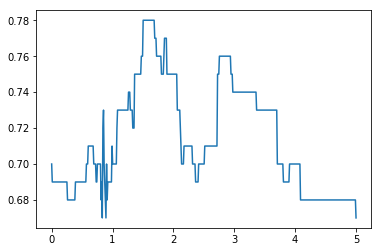

In [29]:
res1 = perform_IRL_4Attrs(optimalAction1, transition_probability,Rmax1 , lamda_list)
accuracy1 = res1['accuracy']
plt.plot(lamda_list, accuracy1)
plt.show()

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  2e+03  4e+00  2e+01  1e+00
 1: -6.7872e+01 -1.6298e+02  6e+02  1e+00  5e+00  2e+00
 2: -6.7433e+01 -1.3010e+02  3e+02  8e-01  4e+00  2e+00
 3: -6.6279e+01 -7.3424e+01  2e+01  1e-01  4e-01  3e-01
 4: -6.6005e+01 -6.6124e+01  4e-01  2e-03  7e-03  6e-03
 5: -6.6000e+01 -6.6001e+01  3e-03  2e-05  7e-05  6e-05
 6: -6.6000e+01 -6.6000e+01  3e-05  2e-07  7e-07  6e-07
 7: -6.6000e+01 -6.6000e+01  3e-07  2e-09  7e-09  6e-09
Optimal solution found.
0.26
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  2e+03  4e+00  2e+01  1e+00
 1: -6.7892e+01 -1.6179e+02  6e+02  1e+00  5e+00  2e+00
 2: -6.7434e+01 -1.2833e+02  3e+02  8e-01  3e+00  2e+00
 3: -6.6258e+01 -7.2953e+01  2e+01  9e-02  4e-01  3e-01
 4: -6.6005e+01 -6.6674e+01  2e+00  9e-03  4e-02  1e-02
 5: -6.6001e+01 -6.6042e+01  7e-02  5e-04  2e-03  1e-03
 6: -6.6000e+01 -6.6000e+01  7e-04  5e-06  2e-05  1e-05
 7: -6.6000e+01 -6.6000

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  2e+03  4e+00  2e+01  1e+00
 1: -6.8159e+01 -1.4716e+02  4e+02  1e+00  4e+00  2e+00
 2: -6.7627e+01 -1.0977e+02  1e+02  6e-01  2e+00  2e+00
 3: -6.6215e+01 -7.0558e+01  9e+00  6e-02  2e-01  3e-01
 4: -6.6004e+01 -6.6075e+01  1e-01  1e-03  4e-03  5e-03
 5: -6.6000e+01 -6.6001e+01  1e-03  1e-05  4e-05  5e-05
 6: -6.6000e+01 -6.6000e+01  1e-05  1e-07  4e-07  5e-07
 7: -6.6000e+01 -6.6000e+01  1e-07  1e-09  4e-09  5e-09
Optimal solution found.
0.36
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  2e+03  4e+00  2e+01  1e+00
 1: -6.8175e+01 -1.4638e+02  4e+02  1e+00  4e+00  2e+00
 2: -6.7643e+01 -1.0884e+02  1e+02  5e-01  2e+00  2e+00
 3: -6.6214e+01 -7.0429e+01  9e+00  6e-02  2e-01  3e-01
 4: -6.6004e+01 -6.6069e+01  1e-01  9e-04  4e-03  5e-03
 5: -6.6000e+01 -6.6001e+01  1e-03  9e-06  4e-05  5e-05
 6: -6.6000e+01 -6.6000e+01  1e-05  9e-08  4e-07  5e-07
 7: -6.6000e+01 -6.6000

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  2e+03  4e+00  1e+01  1e+00
 1: -6.8365e+01 -1.3676e+02  3e+02  9e-01  4e+00  3e+00
 2: -6.7922e+01 -1.0156e+02  1e+02  5e-01  2e+00  2e+00
 3: -6.6218e+01 -6.8995e+01  6e+00  4e-02  2e-01  2e-01
 4: -6.6003e+01 -6.6033e+01  6e-02  4e-04  2e-03  3e-03
 5: -6.6000e+01 -6.6000e+01  6e-04  4e-06  2e-05  3e-05
 6: -6.6000e+01 -6.6000e+01  6e-06  4e-08  2e-07  3e-07
 7: -6.6000e+01 -6.6000e+01  6e-08  4e-10  2e-09  3e-09
Optimal solution found.
0.4
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  2e+03  4e+00  1e+01  1e+00
 1: -6.8374e+01 -1.3624e+02  3e+02  9e-01  4e+00  3e+00
 2: -6.7934e+01 -1.0138e+02  1e+02  5e-01  2e+00  2e+00
 3: -6.6218e+01 -6.8931e+01  6e+00  4e-02  2e-01  2e-01
 4: -6.6003e+01 -6.6032e+01  6e-02  4e-04  2e-03  3e-03
 5: -6.6000e+01 -6.6000e+01  6e-04  4e-06  2e-05  3e-05
 6: -6.6000e+01 -6.6000e+01  6e-06  4e-08  2e-07  3e-07
 7: -6.6000e+01 -6.6000e

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  2e+03  4e+00  1e+01  1e+00
 1: -6.8447e+01 -1.2926e+02  3e+02  8e-01  3e+00  3e+00
 2: -6.7958e+01 -9.8528e+01  9e+01  4e-01  2e+00  2e+00
 3: -6.6211e+01 -6.8277e+01  5e+00  3e-02  1e-01  2e-01
 4: -6.6002e+01 -6.6024e+01  5e-02  3e-04  1e-03  3e-03
 5: -6.6000e+01 -6.6000e+01  5e-04  3e-06  1e-05  3e-05
 6: -6.6000e+01 -6.6000e+01  5e-06  3e-08  1e-07  3e-07
 7: -6.6000e+01 -6.6000e+01  5e-08  3e-10  1e-09  3e-09
Optimal solution found.
0.45
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  2e+03  4e+00  1e+01  1e+00
 1: -6.8447e+01 -1.2890e+02  3e+02  8e-01  3e+00  3e+00
 2: -6.7951e+01 -9.8356e+01  9e+01  4e-01  2e+00  2e+00
 3: -6.6209e+01 -6.8240e+01  5e+00  3e-02  1e-01  2e-01
 4: -6.6002e+01 -6.6023e+01  5e-02  3e-04  1e-03  2e-03
 5: -6.6000e+01 -6.6000e+01  5e-04  3e-06  1e-05  2e-05
 6: -6.6000e+01 -6.6000e+01  5e-06  3e-08  1e-07  2e-07
 7: -6.6000e+01 -6.6000

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  1e+01  1e+00
 1: -6.8384e+01 -1.2407e+02  2e+02  7e-01  3e+00  3e+00
 2: -6.7767e+01 -9.5840e+01  9e+01  4e-01  1e+00  2e+00
 3: -6.6173e+01 -6.7741e+01  4e+00  2e-02  8e-02  2e-01
 4: -6.6002e+01 -6.6018e+01  4e-02  2e-04  8e-04  2e-03
 5: -6.6000e+01 -6.6000e+01  4e-04  2e-06  8e-06  2e-05
 6: -6.6000e+01 -6.6000e+01  4e-06  2e-08  8e-08  2e-07
Optimal solution found.
0.48
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  1e+01  1e+00
 1: -6.8376e+01 -1.2382e+02  2e+02  7e-01  3e+00  3e+00
 2: -6.7753e+01 -9.5702e+01  9e+01  4e-01  1e+00  2e+00
 3: -6.6170e+01 -6.7717e+01  4e+00  2e-02  8e-02  2e-01
 4: -6.6002e+01 -6.6017e+01  4e-02  2e-04  8e-04  2e-03
 5: -6.6000e+01 -6.6000e+01  4e-04  2e-06  8e-06  2e-05
 6: -6.6000e+01 -6.6000e+01  4e-06  2e-08  8e-08  2e-07
Optimal solution found.
0.5
     pcost       dcost       gap    pres   dres   k

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  1e+01  1e+00
 1: -6.8222e+01 -1.2055e+02  2e+02  7e-01  2e+00  3e+00
 2: -6.7525e+01 -9.4287e+01  9e+01  4e-01  1e+00  2e+00
 3: -6.6262e+01 -6.9900e+01  1e+01  5e-02  2e-01  3e-01
 4: -6.6003e+01 -6.6043e+01  1e-01  6e-04  2e-03  3e-03
 5: -6.6000e+01 -6.6000e+01  1e-03  6e-06  2e-05  3e-05
 6: -6.6000e+01 -6.6000e+01  1e-05  6e-08  2e-07  3e-07
 7: -6.6000e+01 -6.6000e+01  1e-07  6e-10  2e-09  3e-09
Optimal solution found.
0.4
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  1e+01  1e+00
 1: -6.8210e+01 -1.2038e+02  2e+02  7e-01  2e+00  3e+00
 2: -6.7512e+01 -9.4250e+01  9e+01  4e-01  1e+00  2e+00
 3: -6.6262e+01 -6.9933e+01  1e+01  5e-02  2e-01  3e-01
 4: -6.6003e+01 -6.6044e+01  1e-01  6e-04  2e-03  3e-03
 5: -6.6000e+01 -6.6000e+01  1e-03  6e-06  2e-05  3e-05
 6: -6.6000e+01 -6.6000e+01  1e-05  6e-08  2e-07  3e-07
 7: -6.6000e+01 -6.6000e

 4: -6.6003e+01 -6.6044e+01  1e-01  6e-04  2e-03  3e-03
 5: -6.6000e+01 -6.6000e+01  1e-03  6e-06  2e-05  3e-05
 6: -6.6000e+01 -6.6000e+01  1e-05  6e-08  2e-07  3e-07
 7: -6.6000e+01 -6.6000e+01  1e-07  6e-10  2e-09  3e-09
Optimal solution found.
0.43
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  1e+01  1e+00
 1: -6.8031e+01 -1.1837e+02  2e+02  7e-01  2e+00  2e+00
 2: -6.7324e+01 -9.3727e+01  9e+01  4e-01  1e+00  1e+00
 3: -6.6227e+01 -6.9929e+01  1e+01  5e-02  2e-01  2e-01
 4: -6.6003e+01 -6.6043e+01  1e-01  6e-04  2e-03  3e-03
 5: -6.6000e+01 -6.6000e+01  1e-03  6e-06  2e-05  3e-05
 6: -6.6000e+01 -6.6000e+01  1e-05  6e-08  2e-07  3e-07
 7: -6.6000e+01 -6.6000e+01  1e-07  6e-10  2e-09  3e-09
Optimal solution found.
0.43
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  1e+01  1e+00
 1: -6.8018e+01 -1.1826e+02  2e+02  7e-01  2e+00  2e+00
 2: -6.7313e+01 -9.3695e+01  9e+01  4e-01  1e+00  

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  1e+01  1e+00
 1: -6.7838e+01 -1.1698e+02  2e+02  7e-01  2e+00  2e+00
 2: -6.7151e+01 -9.3266e+01  9e+01  3e-01  1e+00  1e+00
 3: -6.6158e+01 -6.9038e+01  8e+00  4e-02  1e-01  2e-01
 4: -6.6002e+01 -6.6032e+01  8e-02  4e-04  1e-03  2e-03
 5: -6.6000e+01 -6.6000e+01  8e-04  4e-06  1e-05  2e-05
 6: -6.6000e+01 -6.6000e+01  8e-06  4e-08  1e-07  2e-07
 7: -6.6000e+01 -6.6000e+01  8e-08  4e-10  1e-09  2e-09
Optimal solution found.
0.47
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  1e+01  1e+00
 1: -6.7825e+01 -1.1718e+02  2e+02  7e-01  2e+00  2e+00
 2: -6.7141e+01 -9.3504e+01  9e+01  4e-01  1e+00  1e+00
 3: -6.6094e+01 -6.7497e+01  4e+00  2e-02  5e-02  1e-01
 4: -6.6001e+01 -6.6015e+01  4e-02  2e-04  5e-04  1e-03
 5: -6.6000e+01 -6.6000e+01  4e-04  2e-06  5e-06  1e-05
 6: -6.6000e+01 -6.6000e+01  4e-06  2e-08  5e-08  1e-07
Optimal solution found.

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  9e+00  1e+00
 1: -6.7624e+01 -1.1991e+02  2e+02  7e-01  2e+00  2e+00
 2: -6.6971e+01 -9.4267e+01  1e+02  4e-01  9e-01  1e+00
 3: -6.6081e+01 -6.7596e+01  4e+00  2e-02  5e-02  9e-02
 4: -6.6001e+01 -6.6016e+01  4e-02  2e-04  5e-04  1e-03
 5: -6.6000e+01 -6.6000e+01  4e-04  2e-06  5e-06  1e-05
 6: -6.6000e+01 -6.6000e+01  4e-06  2e-08  5e-08  1e-07
Optimal solution found.
0.43
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  9e+00  1e+00
 1: -6.7613e+01 -1.2000e+02  2e+02  7e-01  2e+00  2e+00
 2: -6.6961e+01 -9.4210e+01  1e+02  4e-01  9e-01  1e+00
 3: -6.6080e+01 -6.7589e+01  4e+00  2e-02  5e-02  9e-02
 4: -6.6001e+01 -6.6016e+01  4e-02  2e-04  5e-04  9e-04
 5: -6.6000e+01 -6.6000e+01  4e-04  2e-06  5e-06  9e-06
 6: -6.6000e+01 -6.6000e+01  4e-06  2e-08  5e-08  9e-08
Optimal solution found.
0.42
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  9e+00  1e+00
 1: -6.7451e+01 -1.2079e+02  2e+02  7e-01  2e+00  2e+00
 2: -6.6821e+01 -9.3479e+01  1e+02  4e-01  8e-01  9e-01
 3: -6.6062e+01 -6.7501e+01  4e+00  2e-02  5e-02  7e-02
 4: -6.6001e+01 -6.6015e+01  4e-02  2e-04  5e-04  8e-04
 5: -6.6000e+01 -6.6000e+01  4e-04  2e-06  5e-06  8e-06
 6: -6.6000e+01 -6.6000e+01  4e-06  2e-08  5e-08  8e-08
Optimal solution found.
0.39
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  9e+00  1e+00
 1: -6.7443e+01 -1.2080e+02  2e+02  7e-01  2e+00  2e+00
 2: -6.6814e+01 -9.3456e+01  1e+02  3e-01  8e-01  9e-01
 3: -6.6061e+01 -6.7499e+01  4e+00  2e-02  5e-02  7e-02
 4: -6.6001e+01 -6.6015e+01  4e-02  2e-04  5e-04  7e-04
 5: -6.6000e+01 -6.6000e+01  4e-04  2e-06  5e-06  7e-06
 6: -6.6000e+01 -6.6000e+01  4e-06  2e-08  5e-08  7e-08
Optimal solution found.
0.39
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  8e+00  1e+00
 1: -6.7312e+01 -1.2042e+02  2e+02  7e-01  2e+00  1e+00
 2: -6.6725e+01 -9.3362e+01  1e+02  3e-01  8e-01  8e-01
 3: -6.6051e+01 -6.7507e+01  5e+00  2e-02  4e-02  6e-02
 4: -6.6001e+01 -6.6015e+01  4e-02  2e-04  4e-04  6e-04
 5: -6.6000e+01 -6.6000e+01  4e-04  2e-06  4e-06  6e-06
 6: -6.6000e+01 -6.6000e+01  4e-06  2e-08  4e-08  6e-08
Optimal solution found.
0.37
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  8e+00  1e+00
 1: -6.7305e+01 -1.2038e+02  2e+02  7e-01  2e+00  1e+00
 2: -6.6721e+01 -9.3370e+01  1e+02  3e-01  8e-01  8e-01
 3: -6.6051e+01 -6.7510e+01  5e+00  2e-02  4e-02  6e-02
 4: -6.6001e+01 -6.6015e+01  4e-02  2e-04  4e-04  6e-04
 5: -6.6000e+01 -6.6000e+01  4e-04  2e-06  4e-06  6e-06
 6: -6.6000e+01 -6.6000e+01  4e-06  2e-08  4e-08  6e-08
Optimal solution found.
0.37
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  7e+00  1e+00
 1: -6.7197e+01 -1.1929e+02  2e+02  7e-01  1e+00  1e+00
 2: -6.6665e+01 -9.3640e+01  1e+02  4e-01  7e-01  7e-01
 3: -6.6045e+01 -6.7579e+01  5e+00  2e-02  4e-02  6e-02
 4: -6.6000e+01 -6.6016e+01  5e-02  2e-04  4e-04  6e-04
 5: -6.6000e+01 -6.6000e+01  5e-04  2e-06  4e-06  6e-06
 6: -6.6000e+01 -6.6000e+01  5e-06  2e-08  4e-08  6e-08
Optimal solution found.
0.37
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  7e+00  1e+00
 1: -6.7192e+01 -1.1922e+02  2e+02  7e-01  1e+00  1e+00
 2: -6.6662e+01 -9.3657e+01  1e+02  4e-01  7e-01  7e-01
 3: -6.6045e+01 -6.7584e+01  5e+00  2e-02  4e-02  6e-02
 4: -6.6000e+01 -6.6016e+01  5e-02  2e-04  4e-04  6e-04
 5: -6.6000e+01 -6.6000e+01  5e-04  2e-06  4e-06  6e-06
 6: -6.6000e+01 -6.6000e+01  5e-06  2e-08  4e-08  6e-08
Optimal solution found.
0.37
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  7e+00  1e+00
 1: -6.7103e+01 -1.1769e+02  2e+02  7e-01  1e+00  1e+00
 2: -6.6621e+01 -9.3698e+01  1e+02  4e-01  7e-01  7e-01
 3: -6.6039e+01 -6.7623e+01  5e+00  2e-02  4e-02  5e-02
 4: -6.6000e+01 -6.6016e+01  5e-02  2e-04  4e-04  5e-04
 5: -6.6000e+01 -6.6000e+01  5e-04  2e-06  4e-06  5e-06
 6: -6.6000e+01 -6.6000e+01  5e-06  2e-08  4e-08  5e-08
Optimal solution found.
0.4
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  7e+00  1e+00
 1: -6.7098e+01 -1.1760e+02  2e+02  7e-01  1e+00  1e+00
 2: -6.6619e+01 -9.3666e+01  1e+02  4e-01  7e-01  7e-01
 3: -6.6038e+01 -6.7620e+01  5e+00  2e-02  4e-02  5e-02
 4: -6.6000e+01 -6.6016e+01  5e-02  2e-04  4e-04  5e-04
 5: -6.6000e+01 -6.6000e+01  5e-04  2e-06  4e-06  5e-06
 6: -6.6000e+01 -6.6000e+01  5e-06  2e-08  4e-08  5e-08
Optimal solution found.
0.4
     pcost       dcost       gap    pres   dres   k/

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  6e+00  1e+00
 1: -6.7024e+01 -1.1580e+02  2e+02  6e-01  1e+00  1e+00
 2: -6.6599e+01 -9.3877e+01  1e+02  4e-01  6e-01  6e-01
 3: -6.6034e+01 -6.7705e+01  6e+00  2e-02  4e-02  5e-02
 4: -6.6000e+01 -6.6017e+01  6e-02  2e-04  4e-04  5e-04
 5: -6.6000e+01 -6.6000e+01  6e-04  2e-06  4e-06  5e-06
 6: -6.6000e+01 -6.6000e+01  6e-06  2e-08  4e-08  5e-08
Optimal solution found.
0.39
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  6e+00  1e+00
 1: -6.7020e+01 -1.1581e+02  2e+02  6e-01  1e+00  1e+00
 2: -6.6596e+01 -9.3889e+01  1e+02  4e-01  6e-01  6e-01
 3: -6.6033e+01 -6.7706e+01  6e+00  2e-02  4e-02  5e-02
 4: -6.6000e+01 -6.6017e+01  6e-02  2e-04  4e-04  5e-04
 5: -6.6000e+01 -6.6000e+01  6e-04  2e-06  4e-06  5e-06
 6: -6.6000e+01 -6.6000e+01  6e-06  2e-08  4e-08  5e-08
Optimal solution found.
0.39
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  6e+00  1e+00
 1: -6.6955e+01 -1.1601e+02  2e+02  6e-01  1e+00  1e+00
 2: -6.6558e+01 -9.4361e+01  1e+02  4e-01  6e-01  6e-01
 3: -6.6029e+01 -6.7737e+01  6e+00  2e-02  4e-02  5e-02
 4: -6.6000e+01 -6.6017e+01  6e-02  2e-04  4e-04  5e-04
 5: -6.6000e+01 -6.6000e+01  6e-04  2e-06  4e-06  5e-06
 6: -6.6000e+01 -6.6000e+01  6e-06  2e-08  4e-08  5e-08
Optimal solution found.
0.4
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  6e+00  1e+00
 1: -6.6952e+01 -1.1602e+02  2e+02  6e-01  1e+00  1e+00
 2: -6.6556e+01 -9.4399e+01  1e+02  4e-01  6e-01  6e-01
 3: -6.6029e+01 -6.7739e+01  6e+00  2e-02  4e-02  5e-02
 4: -6.6000e+01 -6.6017e+01  6e-02  2e-04  4e-04  5e-04
 5: -6.6000e+01 -6.6000e+01  6e-04  2e-06  4e-06  5e-06
 6: -6.6000e+01 -6.6000e+01  6e-06  2e-08  4e-08  5e-08
Optimal solution found.
0.4
     pcost       dcost       gap    pres   dres   k/

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  6e+00  1e+00
 1: -6.6897e+01 -1.1622e+02  3e+02  6e-01  1e+00  9e-01
 2: -6.6526e+01 -9.5016e+01  1e+02  4e-01  6e-01  5e-01
 3: -6.6026e+01 -6.7768e+01  7e+00  2e-02  4e-02  4e-02
 4: -6.6000e+01 -6.6018e+01  7e-02  2e-04  3e-04  4e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  3e-06  4e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  3e-08  4e-08
Optimal solution found.
0.41
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  6e+00  1e+00
 1: -6.6895e+01 -1.1623e+02  3e+02  6e-01  1e+00  9e-01
 2: -6.6524e+01 -9.5051e+01  1e+02  4e-01  6e-01  5e-01
 3: -6.6026e+01 -6.7769e+01  7e+00  2e-02  4e-02  4e-02
 4: -6.6000e+01 -6.6018e+01  7e-02  2e-04  3e-04  4e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  3e-06  4e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  3e-08  4e-08
Optimal solution found.
0.41
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  5e+00  1e+00
 1: -6.6846e+01 -1.1643e+02  3e+02  6e-01  9e-01  8e-01
 2: -6.6495e+01 -9.5639e+01  1e+02  4e-01  5e-01  5e-01
 3: -6.6023e+01 -6.7772e+01  7e+00  2e-02  3e-02  4e-02
 4: -6.6000e+01 -6.6018e+01  7e-02  2e-04  3e-04  4e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  3e-06  4e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  3e-08  4e-08
Optimal solution found.
0.41
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  5e+00  1e+00
 1: -6.6843e+01 -1.1644e+02  3e+02  6e-01  9e-01  8e-01
 2: -6.6493e+01 -9.5670e+01  1e+02  4e-01  5e-01  5e-01
 3: -6.6023e+01 -6.7772e+01  7e+00  2e-02  3e-02  4e-02
 4: -6.6000e+01 -6.6018e+01  7e-02  2e-04  3e-04  4e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  3e-06  4e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  3e-08  4e-08
Optimal solution found.
0.41
     pcost       dcost       gap    pres   dres   

0.4
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  5e+00  1e+00
 1: -6.6802e+01 -1.1663e+02  3e+02  6e-01  9e-01  7e-01
 2: -6.6467e+01 -9.6201e+01  2e+02  4e-01  5e-01  5e-01
 3: -6.6020e+01 -6.7752e+01  7e+00  2e-02  3e-02  4e-02
 4: -6.6000e+01 -6.6017e+01  7e-02  2e-04  3e-04  4e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  3e-06  4e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  3e-08  4e-08
Optimal solution found.
0.4
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  5e+00  1e+00
 1: -6.6800e+01 -1.1664e+02  3e+02  6e-01  9e-01  7e-01
 2: -6.6465e+01 -9.6229e+01  2e+02  4e-01  5e-01  5e-01
 3: -6.6020e+01 -6.7750e+01  7e+00  2e-02  3e-02  4e-02
 4: -6.6000e+01 -6.6017e+01  7e-02  2e-04  3e-04  4e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  3e-06  4e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  3e-08  4e-08
Optimal solution found.
0.4
     pcost       dcost       gap    pres   dres 

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  5e+00  1e+00
 1: -6.6767e+01 -1.1680e+02  3e+02  6e-01  8e-01  7e-01
 2: -6.6443e+01 -9.6686e+01  2e+02  4e-01  5e-01  5e-01
 3: -6.6018e+01 -6.7713e+01  7e+00  2e-02  3e-02  3e-02
 4: -6.6000e+01 -6.6017e+01  7e-02  2e-04  3e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  3e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  3e-08  3e-08
Optimal solution found.
0.38
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  5e+00  1e+00
 1: -6.6765e+01 -1.1681e+02  3e+02  6e-01  8e-01  7e-01
 2: -6.6441e+01 -9.6711e+01  2e+02  4e-01  5e-01  5e-01
 3: -6.6017e+01 -6.7711e+01  7e+00  2e-02  3e-02  3e-02
 4: -6.6000e+01 -6.6017e+01  7e-02  2e-04  3e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  3e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  3e-08  3e-08
Optimal solution found.
0.38
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6737e+01 -1.1695e+02  3e+02  6e-01  8e-01  6e-01
 2: -6.6421e+01 -9.7132e+01  2e+02  4e-01  5e-01  5e-01
 3: -6.6016e+01 -6.7660e+01  7e+00  2e-02  3e-02  3e-02
 4: -6.6000e+01 -6.6017e+01  7e-02  2e-04  3e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  3e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  3e-08  3e-08
Optimal solution found.
0.37
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6735e+01 -1.1696e+02  3e+02  6e-01  8e-01  6e-01
 2: -6.6420e+01 -9.7156e+01  2e+02  4e-01  5e-01  5e-01
 3: -6.6016e+01 -6.7657e+01  7e+00  2e-02  3e-02  3e-02
 4: -6.6000e+01 -6.6016e+01  7e-02  2e-04  3e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  3e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  3e-08  3e-08
Optimal solution found.
0.37
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6709e+01 -1.1708e+02  3e+02  6e-01  8e-01  6e-01
 2: -6.6401e+01 -9.7568e+01  2e+02  4e-01  5e-01  4e-01
 3: -6.6014e+01 -6.7591e+01  7e+00  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6016e+01  7e-02  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  2e-08  3e-08
Optimal solution found.
0.35
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6707e+01 -1.1709e+02  3e+02  6e-01  8e-01  6e-01
 2: -6.6400e+01 -9.7590e+01  2e+02  4e-01  5e-01  4e-01
 3: -6.6014e+01 -6.7587e+01  7e+00  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6016e+01  7e-02  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  2e-08  3e-08
Optimal solution found.
0.35
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6685e+01 -1.1719e+02  3e+02  6e-01  7e-01  6e-01
 2: -6.6385e+01 -9.8046e+01  2e+02  4e-01  5e-01  4e-01
 3: -6.6013e+01 -6.7533e+01  7e+00  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6015e+01  7e-02  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  2e-08  3e-08
Optimal solution found.
0.34
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6683e+01 -1.1720e+02  3e+02  6e-01  7e-01  6e-01
 2: -6.6384e+01 -9.8076e+01  2e+02  4e-01  5e-01  4e-01
 3: -6.6012e+01 -6.7532e+01  7e+00  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6015e+01  7e-02  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  7e-04  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  7e-06  2e-08  2e-08  3e-08
Optimal solution found.
0.34
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6665e+01 -1.1727e+02  3e+02  6e-01  7e-01  5e-01
 2: -6.6373e+01 -9.8570e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6013e+01 -6.7581e+01  8e+00  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6016e+01  8e-02  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  8e-04  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  8e-06  2e-08  2e-08  3e-08
Optimal solution found.
0.32
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6664e+01 -1.1728e+02  3e+02  6e-01  7e-01  5e-01
 2: -6.6373e+01 -9.8598e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6013e+01 -6.7587e+01  8e+00  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6016e+01  8e-02  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  8e-04  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  8e-06  2e-08  2e-08  3e-08
Optimal solution found.
0.32
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6647e+01 -1.1733e+02  3e+02  7e-01  7e-01  5e-01
 2: -6.6363e+01 -9.9057e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6013e+01 -6.7687e+01  9e+00  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6017e+01  8e-02  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  8e-04  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  8e-06  2e-08  2e-08  3e-08
Optimal solution found.
0.35
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6646e+01 -1.1734e+02  3e+02  7e-01  7e-01  5e-01
 2: -6.6363e+01 -9.9083e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6013e+01 -6.7693e+01  9e+00  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6017e+01  9e-02  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  9e-04  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  9e-06  2e-08  2e-08  3e-08
Optimal solution found.
0.35
     pcost       dcost       gap    pres   dres   

0.35
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6631e+01 -1.1737e+02  3e+02  7e-01  6e-01  5e-01
 2: -6.6355e+01 -9.9511e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6014e+01 -6.7788e+01  9e+00  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6018e+01  9e-02  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  9e-04  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  9e-06  2e-08  2e-08  3e-08
Optimal solution found.
0.35
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  4e+00  1e+00
 1: -6.6631e+01 -1.1738e+02  3e+02  7e-01  6e-01  5e-01
 2: -6.6355e+01 -9.9535e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6014e+01 -6.7793e+01  1e+01  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6018e+01  9e-02  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  9e-04  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  9e-06  2e-08  2e-08  3e-08
Optimal solution found.
0.35
     pcost       dcost       gap    pres   dr

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  3e+00  1e+00
 1: -6.6624e+01 -1.1743e+02  3e+02  7e-01  6e-01  5e-01
 2: -6.6349e+01 -9.9768e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6016e+01 -6.7864e+01  1e+01  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6019e+01  1e-01  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  1e-03  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  1e-05  2e-08  2e-08  3e-08
Optimal solution found.
0.36
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  3e+00  1e+00
 1: -6.6624e+01 -1.1744e+02  3e+02  7e-01  6e-01  5e-01
 2: -6.6348e+01 -9.9712e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6016e+01 -6.7860e+01  1e+01  2e-02  2e-02  3e-02
 4: -6.6000e+01 -6.6019e+01  1e-01  2e-04  2e-04  3e-04
 5: -6.6000e+01 -6.6000e+01  1e-03  2e-06  2e-06  3e-06
 6: -6.6000e+01 -6.6000e+01  1e-05  2e-08  2e-08  3e-08
Optimal solution found.
0.36
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  3e+00  1e+00
 1: -6.6619e+01 -1.1769e+02  3e+02  7e-01  6e-01  5e-01
 2: -6.6322e+01 -9.8619e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6016e+01 -6.7756e+01  1e+01  2e-02  2e-02  2e-02
 4: -6.6000e+01 -6.6017e+01  1e-01  2e-04  2e-04  2e-04
 5: -6.6000e+01 -6.6000e+01  1e-03  2e-06  2e-06  2e-06
 6: -6.6000e+01 -6.6000e+01  1e-05  2e-08  2e-08  2e-08
Optimal solution found.
0.38
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  3e+00  1e+00
 1: -6.6618e+01 -1.1770e+02  3e+02  7e-01  6e-01  5e-01
 2: -6.6321e+01 -9.8588e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6016e+01 -6.7753e+01  1e+01  2e-02  2e-02  2e-02
 4: -6.6000e+01 -6.6017e+01  1e-01  2e-04  2e-04  2e-04
 5: -6.6000e+01 -6.6000e+01  1e-03  2e-06  2e-06  2e-06
 6: -6.6000e+01 -6.6000e+01  1e-05  2e-08  2e-08  2e-08
Optimal solution found.
0.38
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  3e+00  1e+00
 1: -6.6614e+01 -1.1791e+02  4e+02  7e-01  6e-01  4e-01
 2: -6.6308e+01 -9.8071e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6016e+01 -6.7696e+01  1e+01  2e-02  2e-02  2e-02
 4: -6.6000e+01 -6.6017e+01  1e-01  2e-04  2e-04  2e-04
 5: -6.6000e+01 -6.6000e+01  1e-03  2e-06  2e-06  2e-06
 6: -6.6000e+01 -6.6000e+01  1e-05  2e-08  2e-08  2e-08
Optimal solution found.
0.37
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  3e+00  1e+00
 1: -6.6614e+01 -1.1792e+02  4e+02  7e-01  6e-01  4e-01
 2: -6.6307e+01 -9.8042e+01  2e+02  4e-01  4e-01  4e-01
 3: -6.6016e+01 -6.7693e+01  1e+01  2e-02  2e-02  2e-02
 4: -6.6000e+01 -6.6017e+01  1e-01  2e-04  2e-04  2e-04
 5: -6.6000e+01 -6.6000e+01  1e-03  2e-06  2e-06  2e-06
 6: -6.6000e+01 -6.6000e+01  1e-05  2e-08  2e-08  2e-08
Optimal solution found.
0.37
     pcost       dcost       gap    pres   dres   

     pcost       dcost       gap    pres   dres   k/t
 0: -6.6697e+01 -3.5149e+02  3e+03  4e+00  3e+00  1e+00
 1: -6.6610e+01 -1.1810e+02  4e+02  7e-01  6e-01  4e-01
 2: -6.6295e+01 -9.7550e+01  2e+02  4e-01  3e-01  4e-01
 3: -6.6016e+01 -6.7639e+01  1e+01  2e-02  2e-02  2e-02
 4: -6.6000e+01 -6.6016e+01  1e-01  2e-04  2e-04  2e-04
 5: -6.6000e+01 -6.6000e+01  1e-03  2e-06  2e-06  2e-06
 6: -6.6000e+01 -6.6000e+01  1e-05  2e-08  2e-08  2e-08
Optimal solution found.
0.38


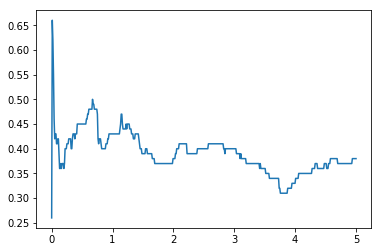

In [30]:
res1_2 = perform_IRL_3Attrs(optimalAction1, transition_probability,Rmax1 , lamda_list)
accuracy1_2 = res1_2['accuracy']
plt.plot(lamda_list, accuracy1_2)
plt.show()

### Q12 find lamda max###

In [31]:
max_accuracy1 = max(accuracy1)
maxLamda1 = lamda_list[accuracy1.index(max_accuracy1)]
print(maxLamda1, max_accuracy1)

1.503006012024048 0.78


In [32]:
max_accuracy1_2 = max(accuracy1_2)
maxLamda1_2 = lamda_list[accuracy1_2.index(max_accuracy1_2)]
print(maxLamda1_2, max_accuracy1_2)

0.01002004008016032 0.66


### Q13 generate heat maps of the ground truth and extracted reward###

In [33]:
# res = perform_IRL_3Attrs(optimalAction1, transition_probability, Rmax1, [maxLamda1_2])
# er = np.zeros([10,10])
# for s in range(100):
#     y = int(s / height)
#     x = int(s % height)
#     er[x,y] = res['reward'][s]
# extracted_reward_max_lamda1 = er

In [34]:
res = perform_IRL_4Attrs(optimalAction1, transition_probability, Rmax1, [maxLamda1])
er = np.zeros([10,10])
for s in range(100):
    y = int(s / height)
    x = int(s % height)
    er[x,y] = res['reward'][s]
extracted_reward_max_lamda1 = er

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.3071e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -6.2532e-01 -0.0000e+00  5e+01  3e+00  8e-01  7e-01
 3: -1.5518e-01 -0.0000e+00  1e+01  8e-01  2e-01  2e-01
 4: -4.0093e-03 -0.0000e+00  7e-01  6e-02  2e-02  6e-03
 5: -3.8872e-05 -0.0000e+00  7e-03  6e-04  2e-04  6e-05
 6: -3.8865e-07 -0.0000e+00  7e-05  6e-06  2e-06  6e-07
 7: -3.8865e-09 -0.0000e+00  7e-07  6e-08  2e-08  6e-09
 8: -3.8865e-11 -0.0000e+00  7e-09  6e-10  2e-10  6e-11
Optimal solution found.
0.78


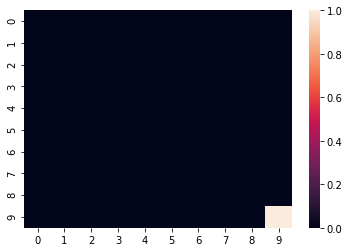

In [35]:
hm_rfunc1 = sns.heatmap(Rfunc1)

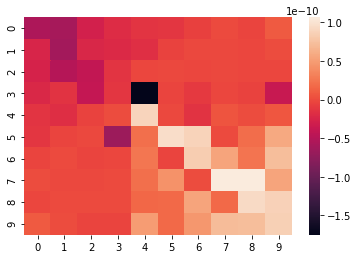

In [36]:
# print(extracted_reward_max_lamda1.reshape((height, width)))
hm_er1 = sns.heatmap(extracted_reward_max_lamda1)

### Q14 compute the optimal values of the states with extracted reward and generate heatmap ###

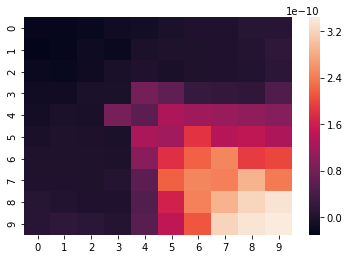

In [37]:
Vs_max_lamda1 = np.zeros(height * width)
calVs(Vs_max_lamda1, tp, extracted_reward_max_lamda1, discount, theta)
Vs_max_lamda1_2d = Vs_max_lamda1.reshape((height, width))
hm_vs = sns.heatmap(Vs_max_lamda1_2d)

### Q16 Use the extracted reward function found in question 13 to compute the optimal policy of the agent. ###

In [38]:
optimalAction_max_lamda1 = np.zeros(height * width)
calOptimalAction(optimalAction_max_lamda1, tp,extracted_reward_max_lamda1 , Vs_max_lamda1, discount)
optimalAction_max_lamda1_2d = optimalAction_max_lamda1.reshape((height, width))
arrows_max_lamda1 = action2Arrow(optimalAction_max_lamda1, arrows)
path_max_lamda1 = np.array(arrows_max_lamda1).reshape((height,width)).T
print(tabulate(optimalAction_max_lamda1_2d.T,  tablefmt='fancy_grid'))
print(tabulate(path_max_lamda1))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 2 │ 1 │ 1 │ 1 │ 0 │ 1 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 1 │ 0 │ 2 │ 1 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 3 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 3 │ 1 │ 1 │ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛
-  -  -  -  -  -  -  -  -  -
3  0  0  0  0  0  0  0  0  1
3  0  0  3  0  0  0  1  0  1
3  3  0  0  0  0  1  3  0  1
3 

In [39]:
# Q18
# print(optimalAction2)
res = perform_IRL_4Attrs(optimalAction2, transition_probability, Rmax2, lamda_list)
accuracy2 = res['accuracy']


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.5466e+00 -0.0000e+00  7e+02  1e+01  9e+00  3e+00
 2: -5.5235e+00 -0.0000e+00  2e+03  1e+01  8e+00  6e+00
 3: -2.0158e+01 -0.0000e+00  8e+03  1e+01  9e+00  2e+01
 4: -1.3025e+02 -0.0000e+00  5e+04  1e+01  9e+00  1e+02
 5: -1.2123e+04 -0.0000e+00  5e+06  1e+01  9e+00  1e+04
 6: -1.2122e+06 -0.0000e+00  5e+08  1e+01  9e+00  1e+06
 7: -1.2122e+08 -0.0000e+00  5e+10  1e+01  9e+00  1e+08
 8: -1.2122e+10 -0.0000e+00  5e+12  1e+01  9e+00  1e+10
Certificate of dual infeasibility found.
0.79
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.5716e+00 -0.0000e+00  7e+02  1e+01  9e+00  3e+00
 2: -5.3086e+00 -0.0000e+00  2e+03  1e+01  8e+00  6e+00
 3: -1.8819e+01 -0.0000e+00  7e+03  1e+01  8e+00  2e+01
 4: -1.1115e+02 -0.0000e+00  4e+04  1e+01  8e+00  1e+02
 5: -1.0113e+04 -0.0000e+00  4e+06  1e+01  8e+00  1e+04
 6: -1

0.81
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.8895e+00 -0.0000e+00  5e+02  1e+01  8e+00  3e+00
 2: -4.0674e+00 -0.0000e+00  7e+02  1e+01  6e+00  4e+00
 3: -1.1239e+01 -0.0000e+00  2e+03  9e+00  5e+00  1e+01
 4: -4.0184e+01 -0.0000e+00  9e+03  8e+00  5e+00  4e+01
 5: -2.3234e+03 -0.0000e+00  5e+05  8e+00  5e+00  2e+03
 6: -2.3221e+05 -0.0000e+00  5e+07  8e+00  5e+00  2e+05
 7: -2.3221e+07 -0.0000e+00  5e+09  8e+00  5e+00  2e+07
 8: -2.3221e+09 -0.0000e+00  5e+11  8e+00  5e+00  2e+09
Certificate of dual infeasibility found.
0.81
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.9117e+00 -0.0000e+00  5e+02  1e+01  8e+00  3e+00
 2: -4.0216e+00 -0.0000e+00  7e+02  1e+01  6e+00  4e+00
 3: -1.0603e+01 -0.0000e+00  2e+03  8e+00  5e+00  1e+01
 4: -3.6329e+01 -0.0000e+00  8e+03  8e+00  5e+00  4e+01
 5: -1.9431e+03 -0.0000e+00  4e+05  8e+00  5e+00  2e+03
 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -3.1436e+00 -0.0000e+00  4e+02  1e+01  7e+00  4e+00
 2: -3.5837e+00 -0.0000e+00  4e+02  8e+00  5e+00  4e+00
 3: -6.1792e+00 -0.0000e+00  8e+02  6e+00  4e+00  6e+00
 4: -1.7671e+01 -0.0000e+00  3e+03  6e+00  4e+00  2e+01
 5: -4.8114e+02 -0.0000e+00  7e+04  5e+00  3e+00  5e+02
 6: -4.7744e+04 -0.0000e+00  7e+06  5e+00  3e+00  5e+04
 7: -4.7744e+06 -0.0000e+00  7e+08  5e+00  3e+00  5e+06
 8: -4.7744e+08 -0.0000e+00  7e+10  5e+00  3e+00  5e+08
Certificate of dual infeasibility found.
0.81
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -3.1565e+00 -0.0000e+00  4e+02  1e+01  7e+00  4e+00
 2: -3.5552e+00 -0.0000e+00  4e+02  8e+00  5e+00  4e+00
 3: -5.9914e+00 -0.0000e+00  8e+02  6e+00  4e+00  6e+00
 4: -1.7063e+01 -0.0000e+00  3e+03  6e+00  4e+00  2e+01
 5: -4.4843e+02 -0.0000e+00  6e+04  5e+00  3e+00  4e+02
 6: -4

 5: -2.8319e+01 -0.0000e+00  4e+03  5e+00  3e+00  3e+01
 6: -2.1799e+03 -0.0000e+00  3e+05  4e+00  3e+00  2e+03
 7: -2.1793e+05 -0.0000e+00  3e+07  4e+00  3e+00  2e+05
 8: -2.1793e+07 -0.0000e+00  3e+09  4e+00  3e+00  2e+07
 9: -2.1793e+09 -0.0000e+00  3e+11  4e+00  3e+00  2e+09
Certificate of dual infeasibility found.
0.81
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -3.1306e+00 -0.0000e+00  4e+02  1e+01  7e+00  3e+00
 2: -3.0690e+00 -0.0000e+00  3e+02  7e+00  4e+00  3e+00
 3: -3.8244e+00 -0.0000e+00  4e+02  5e+00  3e+00  4e+00
 4: -6.4171e+00 -0.0000e+00  8e+02  5e+00  3e+00  7e+00
 5: -2.3886e+01 -0.0000e+00  3e+03  4e+00  3e+00  2e+01
 6: -1.7456e+03 -0.0000e+00  2e+05  4e+00  2e+00  2e+03
 7: -1.7450e+05 -0.0000e+00  2e+07  4e+00  2e+00  2e+05
 8: -1.7449e+07 -0.0000e+00  2e+09  4e+00  2e+00  2e+07
 9: -1.7449e+09 -0.0000e+00  2e+11  4e+00  2e+00  2e+09
Certificate of dual infeasibility found.
0.81
     pcost    

0.83
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.9413e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -2.6307e+00 -0.0000e+00  2e+02  6e+00  3e+00  3e+00
 3: -2.4386e+00 -0.0000e+00  2e+02  4e+00  2e+00  3e+00
 4: -3.2644e+00 -0.0000e+00  4e+02  4e+00  2e+00  3e+00
 5: -7.6268e+00 -0.0000e+00  1e+03  4e+00  2e+00  8e+00
 6: -1.9053e+02 -0.0000e+00  2e+04  3e+00  2e+00  2e+02
 7: -1.8922e+04 -0.0000e+00  2e+06  3e+00  2e+00  2e+04
 8: -1.8922e+06 -0.0000e+00  2e+08  3e+00  2e+00  2e+06
 9: -1.8922e+08 -0.0000e+00  2e+10  3e+00  2e+00  2e+08
Certificate of dual infeasibility found.
0.82
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.9234e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -2.5972e+00 -0.0000e+00  2e+02  6e+00  3e+00  3e+00
 3: -2.3531e+00 -0.0000e+00  2e+02  4e+00  2e+00  2e+00
 4: -3.1142e+00 -0.0000e+00  4e+02  4e+00  2e+00  3e+00
 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.6899e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -2.2145e+00 -0.0000e+00  2e+02  5e+00  3e+00  2e+00
 3: -1.5719e+00 -0.0000e+00  1e+02  3e+00  2e+00  2e+00
 4: -1.8308e+00 -0.0000e+00  2e+02  3e+00  1e+00  2e+00
 5: -3.4313e+00 -0.0000e+00  4e+02  3e+00  1e+00  4e+00
 6: -3.8305e+01 -0.0000e+00  4e+03  2e+00  1e+00  4e+01
 7: -3.6019e+03 -0.0000e+00  4e+05  2e+00  1e+00  4e+03
 8: -3.6017e+05 -0.0000e+00  4e+07  2e+00  1e+00  4e+05
 9: -3.6017e+07 -0.0000e+00  4e+09  2e+00  1e+00  4e+07
Certificate of dual infeasibility found.
0.8
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.6673e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -2.1834e+00 -0.0000e+00  1e+02  5e+00  3e+00  2e+00
 3: -1.5216e+00 -0.0000e+00  1e+02  3e+00  2e+00  2e+00
 4: -1.7404e+00 -0.0000e+00  2e+02  3e+00  1e+00  2e+00
 5: -3.

0.77
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.4254e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -1.8899e+00 -0.0000e+00  1e+02  5e+00  3e+00  2e+00
 3: -1.2351e+00 -0.0000e+00  1e+02  3e+00  2e+00  1e+00
 4: -9.8707e-01 -0.0000e+00  8e+01  2e+00  1e+00  1e+00
 5: -1.0238e+00 -0.0000e+00  2e+02  2e+00  9e-01  1e+00
 6: -1.1247e+00 -0.0000e+00  2e+02  2e+00  8e-01  1e+00
 7: -1.0280e+01 -0.0000e+00  2e+03  1e+00  7e-01  1e+01
 8: -9.9327e+02 -0.0000e+00  2e+05  1e+00  7e-01  1e+03
 9: -9.9318e+04 -0.0000e+00  2e+07  1e+00  7e-01  1e+05
10: -9.9318e+06 -0.0000e+00  2e+09  1e+00  7e-01  1e+07
11: -9.9318e+08 -0.0000e+00  2e+11  1e+00  7e-01  1e+09
Certificate of dual infeasibility found.
0.77
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.4041e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -1.8649e+00 -0.0000e+00  1e+02  5e+00  3e+00  2e+00
 

 3: -1.0244e+00 -0.0000e+00  8e+01  3e+00  2e+00  1e+00
 4: -5.4960e-01 -0.0000e+00  4e+01  2e+00  7e-01  6e-01
 5: -3.6991e-01 -0.0000e+00  6e+01  1e+00  7e-01  4e-01
 6: -4.4406e-01 -0.0000e+00  7e+01  9e-01  4e-01  5e-01
 7: -2.1825e+00 -0.0000e+00  3e+02  7e-01  3e-01  2e+00
 8: -1.8179e+02 -0.0000e+00  3e+04  6e-01  3e-01  2e+02
 9: -1.8174e+04 -0.0000e+00  3e+06  6e-01  3e-01  2e+04
10: -1.8174e+06 -0.0000e+00  3e+08  6e-01  3e-01  2e+06
11: -1.8174e+08 -0.0000e+00  3e+10  6e-01  3e-01  2e+08
Certificate of dual infeasibility found.
0.77
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.1808e+00 -0.0000e+00  3e+02  1e+01  5e+00  3e+00
 2: -1.6056e+00 -0.0000e+00  1e+02  5e+00  2e+00  2e+00
 3: -1.0061e+00 -0.0000e+00  8e+01  3e+00  2e+00  1e+00
 4: -5.2043e-01 -0.0000e+00  4e+01  1e+00  7e-01  6e-01
 5: -3.5387e-01 -0.0000e+00  5e+01  1e+00  7e-01  4e-01
 6: -3.9668e-01 -0.0000e+00  5e+01  8e-01  4e-01  4e-01
 7: 

0.72
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.9960e+00 -0.0000e+00  3e+02  1e+01  5e+00  2e+00
 2: -1.3973e+00 -0.0000e+00  1e+02  5e+00  2e+00  2e+00
 3: -8.3609e-01 -0.0000e+00  7e+01  3e+00  1e+00  9e-01
 4: -3.5405e-01 -0.0000e+00  3e+01  1e+00  6e-01  4e-01
 5: -2.2322e-01 -0.0000e+00  2e+01  9e-01  4e-01  3e-01
 6: -9.7046e-02 -0.0000e+00  9e+00  3e-01  2e-01  1e-01
 7: -8.2896e-02 -0.0000e+00  1e+01  3e-01  1e-01  9e-02
 8: -1.9770e-01 -0.0000e+00  5e+01  2e-01  1e-01  2e-01
 9: -4.7121e+00 -0.0000e+00  1e+03  2e-01  9e-02  5e+00
10: -4.6966e+02 -0.0000e+00  1e+05  2e-01  9e-02  5e+02
11: -4.6965e+04 -0.0000e+00  1e+07  2e-01  9e-02  5e+04
12: -4.6965e+06 -0.0000e+00  1e+09  2e-01  9e-02  5e+06
Certificate of dual infeasibility found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.9785e+00 -0.0000e+00  3e+02  1e+01  5e+00  2e+00
 2

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.8292e+00 -0.0000e+00  3e+02  1e+01  5e+00  2e+00
 2: -1.2223e+00 -0.0000e+00  1e+02  5e+00  2e+00  1e+00
 3: -6.9367e-01 -0.0000e+00  6e+01  3e+00  1e+00  8e-01
 4: -2.5214e-01 -0.0000e+00  2e+01  1e+00  5e-01  3e-01
 5: -3.7749e-02 -0.0000e+00  6e+00  3e-01  1e-01  5e-02
 6: -3.6124e-03 -0.0000e+00  1e+00  1e-01  4e-02  7e-03
 7:  3.1656e-04 -0.0000e+00  2e-01  2e-02  7e-03  2e-04
 8:  5.6680e-06 -0.0000e+00  3e-03  3e-04  1e-04  3e-06
 9:  5.6641e-08 -0.0000e+00  3e-05  3e-06  1e-06  3e-08
10:  5.6640e-10 -0.0000e+00  3e-07  3e-08  1e-08  3e-10
11:  5.6640e-12 -0.0000e+00  3e-09  3e-10  1e-10  3e-12
Optimal solution found.
0.82
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.8135e+00 -0.0000e+00  3e+02  1e+01  5e+00  2e+00
 2: -1.2069e+00 -0.0000e+00  1e+02  5e+00  2e+00  1e+00
 3: -6.8106e-01 -0.0000

 9:  6.5066e-10 -0.0000e+00  7e-07  6e-08  3e-08  1e-09
10:  6.5066e-12 -0.0000e+00  7e-09  6e-10  3e-10  1e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.6328e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -1.0526e+00 -0.0000e+00  1e+02  4e+00  2e+00  1e+00
 3: -5.5980e-01 -0.0000e+00  5e+01  3e+00  1e+00  6e-01
 4: -1.5922e-01 -0.0000e+00  1e+01  8e-01  3e-01  2e-01
 5: -1.8460e-02 -0.0000e+00  3e+00  3e-01  1e-01  3e-02
 6: -3.5656e-04 -0.0000e+00  3e-01  3e-02  1e-02  1e-03
 7:  2.6317e-06 -0.0000e+00  5e-03  5e-04  2e-04  1e-05
 8:  2.6302e-08 -0.0000e+00  5e-05  5e-06  2e-06  1e-07
 9:  2.6301e-10 -0.0000e+00  5e-07  5e-08  2e-08  1e-09
10:  2.6301e-12 -0.0000e+00  5e-09  5e-10  2e-10  1e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.6175e+00 -0.0000e+00  3e+02  1e+01  4e+00  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.4628e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -9.1071e-01 -0.0000e+00  1e+02  4e+00  2e+00  1e+00
 3: -4.5064e-01 -0.0000e+00  5e+01  2e+00  9e-01  5e-01
 4: -9.4853e-02 -0.0000e+00  9e+00  6e-01  2e-01  1e-01
 5: -2.7523e-03 -0.0000e+00  1e+00  1e-01  4e-02  6e-03
 6: -7.4121e-06 -0.0000e+00  3e-02  3e-03  1e-03  9e-05
 7: -7.4235e-08 -0.0000e+00  3e-04  3e-05  1e-05  9e-07
 8: -7.4234e-10 -0.0000e+00  3e-06  3e-07  1e-07  9e-09
 9: -7.4234e-12 -0.0000e+00  3e-08  3e-09  1e-09  9e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.4498e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -9.0004e-01 -0.0000e+00  1e+02  4e+00  2e+00  1e+00
 3: -4.4256e-01 -0.0000e+00  5e+01  2e+00  9e-01  5e-01
 4: -9.0528e-02 -0.0000e+00  9e+00  6e-01  2e-01  1e-01
 5: -2.0053e-03 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.3063e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -7.8422e-01 -0.0000e+00  1e+02  4e+00  2e+00  9e-01
 3: -3.5643e-01 -0.0000e+00  4e+01  2e+00  8e-01  4e-01
 4: -5.6958e-02 -0.0000e+00  7e+00  5e-01  2e-01  7e-02
 5: -3.1759e-03 -0.0000e+00  6e-01  5e-02  2e-02  5e-03
 6: -3.0211e-05 -0.0000e+00  7e-03  6e-04  2e-04  5e-05
 7: -3.0203e-07 -0.0000e+00  7e-05  6e-06  2e-06  5e-07
 8: -3.0203e-09 -0.0000e+00  7e-07  6e-08  2e-08  5e-09
 9: -3.0203e-11 -0.0000e+00  7e-09  6e-10  2e-10  5e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.2953e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -7.7553e-01 -0.0000e+00  1e+02  4e+00  2e+00  9e-01
 3: -3.5008e-01 -0.0000e+00  4e+01  2e+00  8e-01  4e-01
 4: -5.5050e-02 -0.0000e+00  6e+00  5e-01  2e-01  7e-02
 5: -3.0297e-03 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.1733e+00 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -6.8129e-01 -0.0000e+00  9e+01  4e+00  1e+00  8e-01
 3: -2.8252e-01 -0.0000e+00  4e+01  2e+00  7e-01  3e-01
 4: -3.7175e-02 -0.0000e+00  5e+00  4e-01  1e-01  5e-02
 5: -6.7449e-04 -0.0000e+00  3e-01  2e-02  8e-03  1e-03
 6: -6.8872e-06 -0.0000e+00  3e-03  2e-04  8e-05  1e-05
 7: -6.8866e-08 -0.0000e+00  3e-05  2e-06  8e-07  1e-07
 8: -6.8866e-10 -0.0000e+00  3e-07  2e-08  8e-09  1e-09
 9: -6.8866e-12 -0.0000e+00  3e-09  2e-10  8e-11  1e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.1640e+00 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -6.7422e-01 -0.0000e+00  9e+01  4e+00  1e+00  8e-01
 3: -2.7754e-01 -0.0000e+00  4e+01  2e+00  7e-01  3e-01
 4: -3.6505e-02 -0.0000e+00  5e+00  3e-01  1e-01  5e-02
 5: -6.2616e-04 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.0595e+00 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -5.9737e-01 -0.0000e+00  9e+01  4e+00  1e+00  7e-01
 3: -2.2462e-01 -0.0000e+00  3e+01  2e+00  6e-01  3e-01
 4: -2.9063e-02 -0.0000e+00  4e+00  3e-01  9e-02  4e-02
 5: -2.1497e-04 -0.0000e+00  1e-01  1e-02  3e-03  6e-04
 6: -2.1535e-06 -0.0000e+00  1e-03  1e-04  3e-05  6e-06
 7: -2.1535e-08 -0.0000e+00  1e-05  1e-06  3e-07  6e-08
 8: -2.1535e-10 -0.0000e+00  1e-07  1e-08  3e-09  6e-10
 9: -2.1535e-12 -0.0000e+00  1e-09  1e-10  3e-11  6e-12
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.0515e+00 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -5.9159e-01 -0.0000e+00  9e+01  4e+00  1e+00  7e-01
 3: -2.2072e-01 -0.0000e+00  3e+01  2e+00  6e-01  3e-01
 4: -2.8507e-02 -0.0000e+00  4e+00  3e-01  9e-02  4e-02
 5: -1.9976e-04 -0.0000

 1: -9.5451e-01 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -5.2379e-01 -0.0000e+00  9e+01  4e+00  1e+00  7e-01
 3: -1.7625e-01 -0.0000e+00  3e+01  2e+00  5e-01  2e-01
 4: -2.2231e-02 -0.0000e+00  4e+00  2e-01  7e-02  3e-02
 5: -1.7849e-04 -0.0000e+00  7e-02  5e-03  2e-03  3e-04
 6: -1.7839e-06 -0.0000e+00  7e-04  5e-05  2e-05  3e-06
 7: -1.7839e-08 -0.0000e+00  7e-06  5e-07  2e-07  3e-08
 8: -1.7839e-10 -0.0000e+00  7e-08  5e-09  2e-09  3e-10
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -9.4762e-01 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -5.1910e-01 -0.0000e+00  9e+01  4e+00  1e+00  6e-01
 3: -1.7326e-01 -0.0000e+00  3e+01  2e+00  5e-01  2e-01
 4: -2.1810e-02 -0.0000e+00  3e+00  2e-01  7e-02  3e-02
 5: -1.7731e-04 -0.0000e+00  7e-02  5e-03  1e-03  3e-04
 6: -1.7721e-06 -0.0000e+00  7e-04  5e-05  1e-05  3e-06
 7: -1.7720e-08 -0.0000e+00  7e-06  5e-07  1e-07  3e-08
 8: -1.7720e-10 -0.00

 2: -4.6376e-01 -0.0000e+00  9e+01  4e+00  1e+00  6e-01
 3: -1.3907e-01 -0.0000e+00  3e+01  1e+00  4e-01  2e-01
 4: -1.6755e-02 -0.0000e+00  3e+00  2e-01  6e-02  2e-02
 5: -1.5403e-04 -0.0000e+00  4e-02  3e-03  8e-04  2e-04
 6: -1.5395e-06 -0.0000e+00  4e-04  3e-05  8e-06  2e-06
 7: -1.5395e-08 -0.0000e+00  4e-06  3e-07  8e-08  2e-08
 8: -1.5395e-10 -0.0000e+00  4e-08  3e-09  8e-10  2e-10
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -8.5839e-01 -0.0000e+00  3e+02  9e+00  3e+00  1e+00
 2: -4.5991e-01 -0.0000e+00  9e+01  4e+00  1e+00  6e-01
 3: -1.3676e-01 -0.0000e+00  3e+01  1e+00  4e-01  2e-01
 4: -1.6384e-02 -0.0000e+00  3e+00  2e-01  5e-02  2e-02
 5: -1.5157e-04 -0.0000e+00  4e-02  3e-03  7e-04  2e-04
 6: -1.5150e-06 -0.0000e+00  4e-04  3e-05  7e-06  2e-06
 7: -1.5149e-08 -0.0000e+00  4e-06  3e-07  7e-08  2e-08
 8: -1.5149e-10 -0.0000e+00  4e-08  3e-09  7e-10  2e-10
Optimal solution foun

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -7.8118e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -4.1090e-01 -0.0000e+00  9e+01  4e+00  1e+00  5e-01
 3: -1.0844e-01 -0.0000e+00  2e+01  1e+00  3e-01  1e-01
 4: -1.0992e-02 -0.0000e+00  2e+00  1e-01  4e-02  2e-02
 5: -1.0753e-04 -0.0000e+00  2e-02  2e-03  4e-04  2e-04
 6: -1.0750e-06 -0.0000e+00  2e-04  2e-05  4e-06  2e-06
 7: -1.0750e-08 -0.0000e+00  2e-06  2e-07  4e-08  2e-08
 8: -1.0750e-10 -0.0000e+00  2e-08  2e-09  4e-10  2e-10
Optimal solution found.
0.86
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -7.7606e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -4.0772e-01 -0.0000e+00  9e+01  4e+00  1e+00  5e-01
 3: -1.0667e-01 -0.0000e+00  2e+01  1e+00  3e-01  1e-01
 4: -1.0610e-02 -0.0000e+00  2e+00  1e-01  4e-02  1e-02
 5: -1.0399e-04 -0.0000e+00  2e-02  2e-03  4e-04  2e-04
 6: -1.0396e-06 -0.0000

 3: -8.5909e-02 -0.0000e+00  2e+01  1e+00  3e-01  1e-01
 4: -6.0228e-03 -0.0000e+00  1e+00  9e-02  2e-02  9e-03
 5: -6.0717e-05 -0.0000e+00  1e-02  9e-04  2e-04  9e-05
 6: -6.0707e-07 -0.0000e+00  1e-04  9e-06  2e-06  9e-07
 7: -6.0707e-09 -0.0000e+00  1e-06  9e-08  2e-08  9e-09
 8: -6.0707e-11 -0.0000e+00  1e-08  9e-10  2e-10  9e-11
Optimal solution found.
0.86
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -7.0942e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -3.6687e-01 -0.0000e+00  9e+01  4e+00  9e-01  5e-01
 3: -8.4460e-02 -0.0000e+00  2e+01  1e+00  3e-01  1e-01
 4: -5.8398e-03 -0.0000e+00  1e+00  8e-02  2e-02  9e-03
 5: -5.9043e-05 -0.0000e+00  1e-02  9e-04  2e-04  9e-05
 6: -5.9034e-07 -0.0000e+00  1e-04  9e-06  2e-06  9e-07
 7: -5.9034e-09 -0.0000e+00  1e-06  9e-08  2e-08  9e-09
 8: -5.9034e-11 -0.0000e+00  1e-08  9e-10  2e-10  9e-11
Optimal solution found.
0.86
     pcost       dcost       gap    pres   dres 

 7: -3.8612e-09 -0.0000e+00  1e-06  6e-08  1e-08  6e-09
 8: -3.8612e-11 -0.0000e+00  1e-08  6e-10  1e-10  6e-11
Optimal solution found.
0.86
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -6.5094e-01 -0.0000e+00  3e+02  9e+00  2e+00  9e-01
 2: -3.3146e-01 -0.0000e+00  8e+01  4e+00  9e-01  4e-01
 3: -6.5480e-02 -0.0000e+00  2e+01  9e-01  2e-01  1e-01
 4: -3.6780e-03 -0.0000e+00  1e+00  6e-02  1e-02  6e-03
 5: -3.7240e-05 -0.0000e+00  1e-02  6e-04  1e-04  6e-05
 6: -3.7237e-07 -0.0000e+00  1e-04  6e-06  1e-06  6e-07
 7: -3.7237e-09 -0.0000e+00  1e-06  6e-08  1e-08  6e-09
 8: -3.7237e-11 -0.0000e+00  1e-08  6e-10  1e-10  6e-11
Optimal solution found.
0.86
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -6.4704e-01 -0.0000e+00  3e+02  8e+00  2e+00  9e-01
 2: -3.2909e-01 -0.0000e+00  8e+01  4e+00  9e-01  4e-01
 3: -6.4170e-02 -0.0000e+00  2e+01  9e-01  2e-01  

 7: -2.0097e-09 -0.0000e+00  7e-07  4e-08  9e-09  3e-09
 8: -2.0097e-11 -0.0000e+00  7e-09  4e-10  9e-11  3e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.9932e-01 -0.0000e+00  3e+02  8e+00  2e+00  9e-01
 2: -2.9958e-01 -0.0000e+00  8e+01  3e+00  8e-01  4e-01
 3: -5.0308e-02 -0.0000e+00  2e+01  8e-01  2e-01  8e-02
 4: -1.9824e-03 -0.0000e+00  7e-01  4e-02  9e-03  3e-03
 5: -1.9905e-05 -0.0000e+00  7e-03  4e-04  9e-05  3e-05
 6: -1.9904e-07 -0.0000e+00  7e-05  4e-06  9e-07  3e-07
 7: -1.9904e-09 -0.0000e+00  7e-07  4e-08  9e-09  3e-09
 8: -1.9904e-11 -0.0000e+00  7e-09  4e-10  9e-11  3e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.9587e-01 -0.0000e+00  3e+02  8e+00  2e+00  9e-01
 2: -2.9739e-01 -0.0000e+00  8e+01  3e+00  8e-01  4e-01
 3: -5.0020e-02 -0.0000e+00  2e+01  8e-01  2e-01  

 3: -4.4848e-02 -0.0000e+00  2e+01  8e-01  2e-01  7e-02
 4: -1.5286e-03 -0.0000e+00  6e-01  3e-02  7e-03  3e-03
 5: -1.5304e-05 -0.0000e+00  6e-03  3e-04  7e-05  3e-05
 6: -1.5303e-07 -0.0000e+00  6e-05  3e-06  7e-07  3e-07
 7: -1.5303e-09 -0.0000e+00  6e-07  3e-08  7e-09  3e-09
 8: -1.5303e-11 -0.0000e+00  6e-09  3e-10  7e-11  3e-11
Optimal solution found.
0.88
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.5043e-01 -0.0000e+00  3e+02  8e+00  2e+00  8e-01
 2: -2.7530e-01 -0.0000e+00  8e+01  3e+00  7e-01  4e-01
 3: -4.4423e-02 -0.0000e+00  2e+01  8e-01  2e-01  7e-02
 4: -1.4952e-03 -0.0000e+00  6e-01  3e-02  7e-03  2e-03
 5: -1.4967e-05 -0.0000e+00  6e-03  3e-04  7e-05  2e-05
 6: -1.4966e-07 -0.0000e+00  6e-05  3e-06  7e-07  2e-07
 7: -1.4966e-09 -0.0000e+00  6e-07  3e-08  7e-09  2e-09
 8: -1.4966e-11 -0.0000e+00  6e-09  3e-10  7e-11  2e-11
Optimal solution found.
0.88
     pcost       dcost       gap    pres   dres 

 3: -3.8428e-02 -0.0000e+00  1e+01  7e-01  2e-01  6e-02
 4: -1.0934e-03 -0.0000e+00  4e-01  2e-02  5e-03  2e-03
 5: -1.0929e-05 -0.0000e+00  4e-03  2e-04  5e-05  2e-05
 6: -1.0928e-07 -0.0000e+00  4e-05  2e-06  5e-07  2e-07
 7: -1.0928e-09 -0.0000e+00  4e-07  2e-08  5e-09  2e-09
 8: -1.0928e-11 -0.0000e+00  4e-09  2e-10  5e-11  2e-11
Optimal solution found.
0.88
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.0989e-01 -0.0000e+00  3e+02  8e+00  2e+00  8e-01
 2: -2.5519e-01 -0.0000e+00  8e+01  3e+00  7e-01  4e-01
 3: -3.7912e-02 -0.0000e+00  1e+01  7e-01  1e-01  6e-02
 4: -1.0645e-03 -0.0000e+00  4e-01  2e-02  5e-03  2e-03
 5: -1.0639e-05 -0.0000e+00  4e-03  2e-04  5e-05  2e-05
 6: -1.0639e-07 -0.0000e+00  4e-05  2e-06  5e-07  2e-07
 7: -1.0639e-09 -0.0000e+00  4e-07  2e-08  5e-09  2e-09
 8: -1.0639e-11 -0.0000e+00  4e-09  2e-10  5e-11  2e-11
Optimal solution found.
0.88
     pcost       dcost       gap    pres   dres 

0.88
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.7355e-01 -0.0000e+00  2e+02  8e+00  2e+00  7e-01
 2: -2.3320e-01 -0.0000e+00  8e+01  3e+00  6e-01  3e-01
 3: -2.8713e-02 -0.0000e+00  1e+01  6e-01  1e-01  5e-02
 4: -6.9406e-04 -0.0000e+00  3e-01  2e-02  3e-03  1e-03
 5: -6.9339e-06 -0.0000e+00  3e-03  2e-04  3e-05  1e-05
 6: -6.9337e-08 -0.0000e+00  3e-05  2e-06  3e-07  1e-07
 7: -6.9337e-10 -0.0000e+00  3e-07  2e-08  3e-09  1e-09
 8: -6.9337e-12 -0.0000e+00  3e-09  2e-10  3e-11  1e-11
Optimal solution found.
0.88
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.7110e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -2.3146e-01 -0.0000e+00  7e+01  3e+00  6e-01  3e-01
 3: -2.7806e-02 -0.0000e+00  1e+01  6e-01  1e-01  5e-02
 4: -6.6476e-04 -0.0000e+00  3e-01  1e-02  3e-03  1e-03
 5: -6.6414e-06 -0.0000e+00  3e-03  1e-04  3e-05  1e-05
 6: -6.6413e-08 -0

0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.3469e-01 -0.0000e+00  3e+02  7e+00  1e+00  7e-01
 2: -2.1502e-01 -0.0000e+00  7e+01  3e+00  6e-01  3e-01
 3: -2.2093e-02 -0.0000e+00  1e+01  5e-01  1e-01  4e-02
 4: -4.7184e-04 -0.0000e+00  2e-01  1e-02  2e-03  8e-04
 5: -4.7148e-06 -0.0000e+00  2e-03  1e-04  2e-05  8e-06
 6: -4.7148e-08 -0.0000e+00  2e-05  1e-06  2e-07  8e-08
 7: -4.7148e-10 -0.0000e+00  2e-07  1e-08  2e-09  8e-10
 8: -4.7148e-12 -0.0000e+00  2e-09  1e-10  2e-11  8e-12
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.3213e-01 -0.0000e+00  3e+02  7e+00  1e+00  7e-01
 2: -2.1414e-01 -0.0000e+00  7e+01  3e+00  6e-01  3e-01
 3: -2.1936e-02 -0.0000e+00  1e+01  5e-01  1e-01  4e-02
 4: -4.6551e-04 -0.0000e+00  2e-01  1e-02  2e-03  8e-04
 5: -4.6515e-06 -0.0000e+00  2e-03  1e-04  2e-05  8e-06
 6: -4.6515e-08 -0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.0070e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -2.0330e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.9856e-02 -0.0000e+00  1e+01  5e-01  9e-02  4e-02
 4: -3.8688e-04 -0.0000e+00  2e-01  1e-02  2e-03  7e-04
 5: -3.8661e-06 -0.0000e+00  2e-03  1e-04  2e-05  7e-06
 6: -3.8661e-08 -0.0000e+00  2e-05  1e-06  2e-07  7e-08
 7: -3.8661e-10 -0.0000e+00  2e-07  1e-08  2e-09  7e-10
 8: -3.8661e-12 -0.0000e+00  2e-09  1e-10  2e-11  7e-12
Optimal solution found.
0.86
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -3.9842e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -2.0251e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.9693e-02 -0.0000e+00  1e+01  5e-01  9e-02  4e-02
 4: -3.8115e-04 -0.0000e+00  2e-01  1e-02  2e-03  7e-04
 5: -3.8089e-06 -0.0000e+00  2e-03  1e-04  2e-05  7e-06
 6: -3.8088e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -3.7025e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -1.9285e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.7589e-02 -0.0000e+00  1e+01  5e-01  8e-02  3e-02
 4: -3.1122e-04 -0.0000e+00  2e-01  8e-03  1e-03  6e-04
 5: -3.1102e-06 -0.0000e+00  2e-03  8e-05  1e-05  6e-06
 6: -3.1102e-08 -0.0000e+00  2e-05  8e-07  1e-07  6e-08
 7: -3.1102e-10 -0.0000e+00  2e-07  8e-09  1e-09  6e-10
 8: -3.1102e-12 -0.0000e+00  2e-09  8e-11  1e-11  6e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -3.6819e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -1.9215e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.7428e-02 -0.0000e+00  1e+01  5e-01  8e-02  3e-02
 4: -3.0619e-04 -0.0000e+00  2e-01  8e-03  1e-03  6e-04
 5: -3.0600e-06 -0.0000e+00  2e-03  8e-05  1e-05  6e-06
 6: -3.0600e-08 -0.0000

 3: -1.5900e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.6065e-04 -0.0000e+00  2e-01  7e-03  1e-03  5e-04
 5: -2.6050e-06 -0.0000e+00  2e-03  7e-05  1e-05  5e-06
 6: -2.6050e-08 -0.0000e+00  2e-05  7e-07  1e-07  5e-08
 7: -2.6050e-10 -0.0000e+00  2e-07  7e-09  1e-09  5e-10
 8: -2.6050e-12 -0.0000e+00  2e-09  7e-11  1e-11  5e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -3.4100e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -1.8295e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.5818e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.5849e-04 -0.0000e+00  2e-01  7e-03  1e-03  5e-04
 5: -2.5834e-06 -0.0000e+00  2e-03  7e-05  1e-05  5e-06
 6: -2.5834e-08 -0.0000e+00  2e-05  7e-07  1e-07  5e-08
 7: -2.5834e-10 -0.0000e+00  2e-07  7e-09  1e-09  5e-10
 8: -2.5834e-12 -0.0000e+00  2e-09  7e-11  1e-11  5e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres 

 3: -1.4829e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3289e-04 -0.0000e+00  1e-01  6e-03  1e-03  4e-04
 5: -2.3277e-06 -0.0000e+00  1e-03  6e-05  1e-05  4e-06
 6: -2.3277e-08 -0.0000e+00  1e-05  6e-07  1e-07  4e-08
 7: -2.3277e-10 -0.0000e+00  1e-07  6e-09  1e-09  4e-10
 8: -2.3277e-12 -0.0000e+00  1e-09  6e-11  1e-11  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -3.1645e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -1.7481e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.4758e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3110e-04 -0.0000e+00  1e-01  6e-03  1e-03  4e-04
 5: -2.3098e-06 -0.0000e+00  1e-03  6e-05  1e-05  4e-06
 6: -2.3098e-08 -0.0000e+00  1e-05  6e-07  1e-07  4e-08
 7: -2.3098e-10 -0.0000e+00  1e-07  6e-09  1e-09  4e-10
 8: -2.3098e-12 -0.0000e+00  1e-09  6e-11  1e-11  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres 

 2: -1.6930e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4685e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3537e-04 -0.0000e+00  1e-01  6e-03  1e-03  4e-04
 5: -2.3525e-06 -0.0000e+00  1e-03  6e-05  1e-05  4e-06
 6: -2.3525e-08 -0.0000e+00  1e-05  6e-07  1e-07  4e-08
 7: -2.3525e-10 -0.0000e+00  1e-07  6e-09  1e-09  4e-10
 8: -2.3525e-12 -0.0000e+00  1e-09  6e-11  1e-11  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.9766e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.6894e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4691e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3599e-04 -0.0000e+00  1e-01  6e-03  1e-03  4e-04
 5: -2.3587e-06 -0.0000e+00  1e-03  6e-05  1e-05  4e-06
 6: -2.3587e-08 -0.0000e+00  1e-05  6e-07  1e-07  4e-08
 7: -2.3587e-10 -0.0000e+00  1e-07  6e-09  1e-09  4e-10
 8: -2.3587e-12 -0.0000e+00  1e-09  6e-11  1e-11  4e-12
Optimal solution foun

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.8197e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.6424e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4746e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3900e-04 -0.0000e+00  2e-01  6e-03  1e-03  4e-04
 5: -2.3889e-06 -0.0000e+00  2e-03  6e-05  1e-05  4e-06
 6: -2.3889e-08 -0.0000e+00  2e-05  6e-07  1e-07  4e-08
 7: -2.3889e-10 -0.0000e+00  2e-07  6e-09  1e-09  4e-10
 8: -2.3889e-12 -0.0000e+00  2e-09  6e-11  1e-11  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.8090e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.6393e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4748e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3882e-04 -0.0000e+00  2e-01  6e-03  1e-03  4e-04
 5: -2.3870e-06 -0.0000e+00  2e-03  6e-05  1e-05  4e-06
 6: -2.3870e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.6761e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.6014e-01 -0.0000e+00  9e+01  3e+00  4e-01  3e-01
 3: -1.4756e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.3552e-04 -0.0000e+00  2e-01  6e-03  1e-03  4e-04
 5: -2.3541e-06 -0.0000e+00  2e-03  6e-05  1e-05  4e-06
 6: -2.3541e-08 -0.0000e+00  2e-05  6e-07  1e-07  4e-08
 7: -2.3541e-10 -0.0000e+00  2e-07  6e-09  1e-09  4e-10
 8: -2.3541e-12 -0.0000e+00  2e-09  6e-11  1e-11  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.6664e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5987e-01 -0.0000e+00  9e+01  3e+00  4e-01  3e-01
 3: -1.4756e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.3521e-04 -0.0000e+00  2e-01  6e-03  9e-04  4e-04
 5: -2.3510e-06 -0.0000e+00  2e-03  6e-05  9e-06  4e-06
 6: -2.3510e-08 -0.0000

 5: -2.3052e-06 -0.0000e+00  2e-03  6e-05  9e-06  4e-06
 6: -2.3052e-08 -0.0000e+00  2e-05  6e-07  9e-08  4e-08
 7: -2.3052e-10 -0.0000e+00  2e-07  6e-09  9e-10  4e-10
 8: -2.3052e-12 -0.0000e+00  2e-09  6e-11  9e-12  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.5356e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5635e-01 -0.0000e+00  9e+01  3e+00  4e-01  3e-01
 3: -1.4729e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.3024e-04 -0.0000e+00  2e-01  6e-03  9e-04  4e-04
 5: -2.3013e-06 -0.0000e+00  2e-03  6e-05  9e-06  4e-06
 6: -2.3013e-08 -0.0000e+00  2e-05  6e-07  9e-08  4e-08
 7: -2.3013e-10 -0.0000e+00  2e-07  6e-09  9e-10  4e-10
 8: -2.3013e-12 -0.0000e+00  2e-09  6e-11  9e-12  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.5267e-01 -0.0000e+00  3e+02  8e+00  1e+00  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.4155e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5333e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4674e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.2441e-04 -0.0000e+00  2e-01  6e-03  9e-04  4e-04
 5: -2.2431e-06 -0.0000e+00  2e-03  6e-05  9e-06  4e-06
 6: -2.2431e-08 -0.0000e+00  2e-05  6e-07  9e-08  4e-08
 7: -2.2431e-10 -0.0000e+00  2e-07  6e-09  9e-10  4e-10
 8: -2.2431e-12 -0.0000e+00  2e-09  6e-11  9e-12  4e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.4073e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5314e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4670e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.2397e-04 -0.0000e+00  2e-01  6e-03  9e-04  4e-04
 5: -2.2387e-06 -0.0000e+00  2e-03  6e-05  9e-06  4e-06
 6: -2.2387e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.3049e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5076e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4597e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.1808e-04 -0.0000e+00  2e-01  6e-03  8e-04  4e-04
 5: -2.1798e-06 -0.0000e+00  2e-03  6e-05  8e-06  4e-06
 6: -2.1798e-08 -0.0000e+00  2e-05  6e-07  8e-08  4e-08
 7: -2.1798e-10 -0.0000e+00  2e-07  6e-09  8e-10  4e-10
 8: -2.1798e-12 -0.0000e+00  2e-09  6e-11  8e-12  4e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.2974e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5060e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4591e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.1761e-04 -0.0000e+00  2e-01  6e-03  8e-04  4e-04
 5: -2.1752e-06 -0.0000e+00  2e-03  6e-05  8e-06  4e-06
 6: -2.1752e-08 -0.0000

 5: -2.1139e-06 -0.0000e+00  2e-03  6e-05  8e-06  4e-06
 6: -2.1139e-08 -0.0000e+00  2e-05  6e-07  8e-08  4e-08
 7: -2.1139e-10 -0.0000e+00  2e-07  6e-09  8e-10  4e-10
 8: -2.1139e-12 -0.0000e+00  2e-09  6e-11  8e-12  4e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.1960e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.4847e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4494e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.1101e-04 -0.0000e+00  2e-01  6e-03  8e-04  4e-04
 5: -2.1092e-06 -0.0000e+00  2e-03  6e-05  8e-06  4e-06
 6: -2.1092e-08 -0.0000e+00  2e-05  6e-07  8e-08  4e-08
 7: -2.1092e-10 -0.0000e+00  2e-07  6e-09  8e-10  4e-10
 8: -2.1092e-12 -0.0000e+00  2e-09  6e-11  8e-12  4e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.1891e-01 -0.0000e+00  3e+02  8e+00  1e+00  

 2: -1.4671e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4380e-02 -0.0000e+00  1e+01  4e-01  5e-02  3e-02
 4: -2.0431e-04 -0.0000e+00  2e-01  6e-03  7e-04  4e-04
 5: -2.0423e-06 -0.0000e+00  2e-03  6e-05  7e-06  4e-06
 6: -2.0423e-08 -0.0000e+00  2e-05  6e-07  7e-08  4e-08
 7: -2.0423e-10 -0.0000e+00  2e-07  6e-09  7e-10  4e-10
 8: -2.0423e-12 -0.0000e+00  2e-09  6e-11  7e-12  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.0960e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.4660e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4371e-02 -0.0000e+00  1e+01  4e-01  5e-02  3e-02
 4: -2.0384e-04 -0.0000e+00  2e-01  6e-03  7e-04  4e-04
 5: -2.0376e-06 -0.0000e+00  2e-03  6e-05  7e-06  4e-06
 6: -2.0375e-08 -0.0000e+00  2e-05  6e-07  7e-08  4e-08
 7: -2.0375e-10 -0.0000e+00  2e-07  6e-09  7e-10  4e-10
 8: -2.0375e-12 -0.0000e+00  2e-09  6e-11  7e-12  4e-12
Optimal solution foun

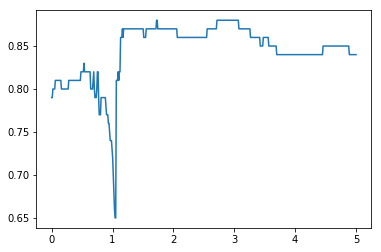

In [40]:
# Q18
plt.plot(lamda_list, accuracy2)
plt.show()

In [41]:
# Q19
max_accuracy2 = max(accuracy2)
maxLamda2 = lamda_list[accuracy2.index(max_accuracy2)]
print(maxLamda2, max_accuracy2)

1.723446893787575 0.88


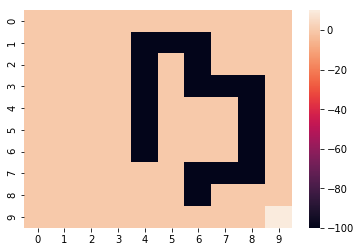

In [42]:
# Q20
hm_rfunc2 = sns.heatmap(Rfunc2)


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.0760e+00 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -6.0921e-01 -0.0000e+00  9e+01  4e+00  1e+00  7e-01
 3: -2.3263e-01 -0.0000e+00  3e+01  2e+00  6e-01  3e-01
 4: -3.0209e-02 -0.0000e+00  4e+00  3e-01  1e-01  4e-02
 5: -2.5375e-04 -0.0000e+00  2e-01  1e-02  4e-03  6e-04
 6: -2.5450e-06 -0.0000e+00  2e-03  1e-04  4e-05  6e-06
 7: -2.5448e-08 -0.0000e+00  2e-05  1e-06  4e-07  6e-08
 8: -2.5448e-10 -0.0000e+00  2e-07  1e-08  4e-09  6e-10
 9: -2.5448e-12 -0.0000e+00  2e-09  1e-10  4e-11  6e-12
Optimal solution found.
0.88


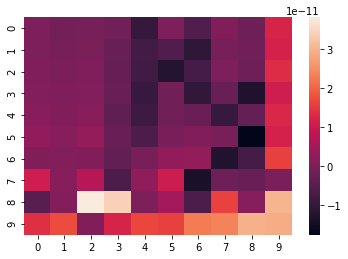

In [43]:
res = perform_IRL_4Attrs(optimalAction2, transition_probability, Rmax2, [maxLamda2])
er2 = np.zeros([10,10])
for s in range(100):
    y = int(s / height)
    x = int(s % height)
    er2[x,y] = res['reward'][s]
extracted_reward_max_lamda2 = er2
hm_er2 = sns.heatmap(extracted_reward_max_lamda2)

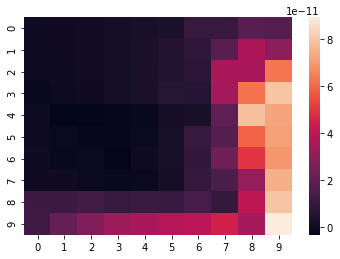

In [44]:
#Q21
Vs_max_lamda2 = np.zeros(height * width)
calVs(Vs_max_lamda2, tp, extracted_reward_max_lamda2, discount, theta)
Vs_max_lamda2_2d = Vs_max_lamda2.reshape((height, width))
hm_vs = sns.heatmap(Vs_max_lamda2_2d)

In [45]:
#Q23
optimalAction_max_lamda2 = np.zeros(height * width)
calOptimalAction(optimalAction_max_lamda2, tp,extracted_reward_max_lamda2 , Vs_max_lamda2, discount)
optimalAction_max_lamda2_2d = optimalAction_max_lamda2.reshape((height, width))
arrows_max_lamda2 = action2Arrow(optimalAction_max_lamda2, arrows)
path_max_lamda2 = np.array(arrows_max_lamda2).reshape((height,width)).T
print(tabulate(optimalAction_max_lamda2_2d.T,  tablefmt='fancy_grid'))
print(tabulate(path_max_lamda2))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 3 │ 2 │ 3 │ 1 │ 0 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 0 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 0 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 3 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 3 │ 3 │ 1 │ 1 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 3 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 2 │ 3 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 0 │ 3 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛
-  -  -  -  -  -  -  -  -  -
3  2  3  2  0  1  0  0  0  3
3  3  3  2  2  1  0  0  0  3
3  3  3  2  2  3  0  0  0  3
3 